#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 50

In [6]:
mi = [mp for i in range(node_N)] 

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 169 # [m]
Xg = 78 # [m]
mn = 123000000 # mass of the vessel, [kg]  Solitaire type vessel 
kp, kd=1.95e4,1.5e4

In [8]:
vessel_mass=mn/L # mass over length of the vessel

In [9]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
 
Irho=np.diag(diag_Irho)

In [10]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [11]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [12]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [13]:
Irho+=vessel_inertia

In [14]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [15]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [16]:
E = 210e9

In [17]:
E*Ar

16991625880.187403

In [18]:
diag_DT = 1.5*np.array([1, 1, 1]) 

In [19]:
DT=np.diag(diag_DT) # (35) in [2]

In [20]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [21]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [22]:
CT=np.diag(diag_CT)

In [23]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [24]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [25]:
Re_t_([1,2,3])

array([[ 0.41198225,  0.05872664,  0.90929743],
       [-0.68124272, -0.64287284,  0.35017549],
       [ 0.60512725, -0.76371834, -0.2248451 ]])

In [26]:
rng = np.random.default_rng()

In [27]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [28]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [29]:
Re_t_(np.array([φ[0], θ[0], ψ[0]]))

array([[ 0.26499426, -0.92344148,  0.27754978],
       [-0.76812389, -0.02816086,  0.63968169],
       [-0.58289256, -0.3827046 , -0.71677992]])

In [30]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.007758


In [31]:
Ret.shape

(50, 3, 3)

In [32]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [33]:
def C1(dx,dy,dz, Ret):
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))) 
    return ans.T

In [34]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000458


In [35]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [36]:
fD(dx,dy,dz,DT,Ret).T

array([[ 1.74308224e+04,  3.92424568e+04,  1.75354612e+04],
       [-4.95540652e+02,  6.89671489e+03, -6.60562373e+03],
       [ 2.48917811e+03, -5.48435472e+03,  3.93131478e+03],
       [-7.43481331e+01,  5.20533855e+01,  2.42433269e+03],
       [-6.50127426e+03, -1.03400822e+04, -1.71735258e+01],
       [ 8.94196628e+02, -8.69124394e+02,  6.75265235e+03],
       [ 3.03699207e+02, -2.51421232e+03, -3.45470328e+02],
       [ 1.87868708e+04,  3.21297017e+04, -2.94986028e+04],
       [ 1.23426383e+03, -2.76798321e+03,  5.03277004e+03],
       [-2.07915449e+02,  1.32446102e+04,  2.54372748e+04],
       [ 6.67829944e+03,  3.02923105e+03, -1.35557830e+04],
       [-3.17001458e+04, -3.66791319e+04, -1.95099704e+04],
       [-3.09615150e+04, -4.30261684e+04,  2.59665185e+04],
       [ 2.89146136e+04,  1.36946775e+04,  1.00173201e+04],
       [ 1.81344128e+03, -5.24513362e+03, -2.60487285e+03],
       [-8.48142179e+02,  1.29400645e+03, -4.50439461e+01],
       [-1.39741672e+03,  2.39986278e+03

In [37]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000430


In [38]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [39]:
I=np.identity(3)

In [40]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000445


In [41]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [42]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [43]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [44]:
DR=np.diag(diag_DR) 

In [45]:
Ar

0.08091250419136858

In [46]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [47]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [48]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [49]:
def Re_b(Ret):
    return Ret

In [50]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000171


In [51]:
def phi(x, y, z, Ret,dummy):
    B=np.vstack([x,y,z])
    return np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))

In [52]:
phi(x,y,z,Ret,None)

array([[-0.73986876, -0.06139837,  1.5194544 ],
       [-0.47101827, -0.34834357, -0.02498898],
       [ 0.75243842, -0.77699569,  1.85083811],
       [ 1.26675809, -0.02354794,  0.30247123],
       [ 0.46199559, -1.70375577,  0.07923152],
       [ 0.12709286, -1.16683422, -0.26952531],
       [-0.08896766,  0.10951846, -1.10015221],
       [-0.97994663, -0.3010892 ,  2.25589885],
       [-0.75049608,  1.91337659, -0.84350484],
       [ 0.07560881,  0.18617264, -0.74159115],
       [-1.88055061, -0.06553314, -0.50333489],
       [-0.68979228, -0.49066604,  0.48845646],
       [ 0.03378228,  0.40846973, -0.31265282],
       [ 0.20594015,  0.70039237,  0.79253708],
       [ 1.06205   ,  0.21657352, -0.64642849],
       [ 1.12417617,  0.31360506,  1.96311936],
       [-0.76950899, -0.22129331, -0.24847084],
       [ 0.94175531, -0.65214819,  0.31573674],
       [ 0.35289405, -0.21733371, -0.73244554],
       [-0.24537471,  0.07066249, -1.10772136],
       [ 0.31259801, -0.13783676,  0.756

In [53]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None)
print(datetime.now() - startTime1)

0:00:00.000315


In [54]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [55]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [56]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.002398


In [57]:
def ωe(φ,θ,ψ, dummy,dummy1):  # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float32))

In [58]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None)
print(datetime.now() - startTime1)

0:00:00.002000


In [59]:
ωe(φ,θ,ψ,None,None)

array([[-1.083141  ,  4.0923242 ,  1.12399392],
       [ 0.91317252,  0.3341018 , -0.54887076],
       [ 1.82379647, -0.0963742 ,  1.52306906],
       [-0.17326497, -0.79656888, -0.06886774],
       [-1.93775618, -0.50730667, -1.65035122],
       [ 0.45381966,  0.52065849, -0.71520917],
       [-0.13846595,  0.95759824, -0.74924749],
       [-0.11493125,  2.5709266 ,  0.76084368],
       [ 0.66712899,  1.62815596, -1.32891924],
       [-1.44186691, -2.16259713,  1.88779734],
       [ 1.15545674,  1.04128422, -0.57776351],
       [ 1.3158683 , -0.71397307,  0.43839334],
       [-1.02415458,  0.3561695 ,  0.42503788],
       [ 0.13424529, -0.46084668, -2.13875964],
       [-1.99768284,  1.36375726,  1.9652966 ],
       [-0.99758575, -0.1099423 ,  1.01808363],
       [-1.64625602, -2.28071249, -0.73134014],
       [ 1.73848983, -1.22436668,  0.58668443],
       [-0.46464177, -0.23942258, -0.10574374],
       [-0.17669341,  0.82418481, -0.13168822],
       [ 1.48833909,  0.0317165 ,  0.206

In [60]:
def d_s(f,a,b,c,Ret,omega):

    fun = f(a,b,c,Ret,omega)    
    
    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)
  
    return np.einsum('ijk,ik->ij',K, fun.astype(np.float32)).T

In [61]:
φ, θ, ψ = np.array([0.00001 for i in range(node_N)]),np.array([0.00001 for i in range(node_N)]),np.array([0.00001 for i in range(node_N)])

In [62]:
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[ 1.58083688e-05,  3.23351325e-06,  2.62780744e-05,
         3.26015888e-06,  1.78296938e-05,  8.97299920e-06,
        -1.20965859e-05,  2.55696252e-05, -2.75685378e-05,
        -9.27754504e-06, -4.37797352e-06,  9.79112674e-06,
        -7.21115333e-06,  9.21438040e-07, -8.62993335e-06,
         1.64949778e-05, -2.71772700e-07,  9.67875225e-06,
        -5.15106655e-06, -1.17837201e-05,  8.93931904e-06,
        -2.88964556e-06,  1.74263608e-06, -1.42939011e-05,
         6.03452534e-06,  9.43473685e-06,  9.78828795e-06,
         9.51220736e-06, -3.67296196e-05, -1.39436123e-05,
         6.68532190e-06,  2.10818090e-05,  2.06677481e-05,
         1.77485981e-06, -7.74308429e-07,  1.27101947e-05,
         9.98421137e-06, -4.26677956e-06,  2.77635145e-06,
         4.11583828e-07, -2.82797884e-06,  1.23449442e-05,
         2.69788660e-05,  8.25505802e-06,  3.44096549e-06,
        -8.40199392e-06,  1.68069904e-05,  8.16049054e-06,
        -6.16341909e-06,  1.41881116e-06],
       [-2.25

In [63]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.001822


In [64]:
def ne(x,y,z,Ret,omega):
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float32),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float32), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [65]:
φ, θ, ψ = np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [66]:
d_s(ne,x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[ 2.98865626e+02, -1.48697341e+01,  3.05515042e+02,
        -1.33668410e+02,  3.76880446e+02,  7.30702147e+01,
         3.50508129e+01, -1.94499261e+02,  2.00518986e+02,
        -1.78369589e+02,  2.19766792e+02, -2.65459694e+01,
        -5.06163573e+01, -2.87736692e+02, -1.89495302e+02,
        -1.90899403e+02,  5.24979714e+01, -3.97262432e+01,
        -6.09276029e+01,  1.05251366e+02,  4.93046256e-01,
         1.60229135e+02,  5.82093296e+01, -2.61637282e+02,
         2.08793055e+02, -3.18805320e+02, -6.52154302e+01,
         3.86743580e+02, -2.57607351e+02,  2.10276439e+02,
         5.13621309e+02,  1.19243354e+02,  4.59778579e+01,
         1.85156018e+02, -3.84688031e+02,  7.29732388e+01,
         8.70490647e+01, -1.96617493e+02,  1.39039821e+02,
         6.77792489e+01,  4.75865456e+01, -3.48187993e+02,
         2.45148546e+02,  8.42583250e+01,  1.07325763e+02,
        -2.21853890e+02, -4.88058551e+01,  1.29751726e+02,
         3.90164552e+02, -6.08879390e-01],
       [-3.18

In [67]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[ 4.72181800e-07, -2.02609127e-07, -9.31524297e-08,
        -6.32166512e-07, -1.72985970e-06,  1.82779850e-06,
        -1.50412218e-06, -2.15918658e-06, -2.04910654e-06,
         4.93667603e-07,  2.24132078e-06, -4.47172074e-08,
        -2.38091975e-07,  1.73895095e-07,  1.20201252e-06,
         3.13528092e-06, -6.76071577e-07,  1.09188715e-06,
        -1.09022657e-06, -1.64902319e-06, -8.09341010e-07,
        -5.37372050e-07,  3.12372395e-06, -9.35734273e-07,
        -4.96270099e-07,  1.70191001e-06,  5.47106194e-07,
         4.18131752e-07, -2.27566771e-06, -2.16113655e-06,
        -1.17397280e-07,  2.85503101e-07,  1.07193231e-06,
        -9.84016199e-07,  1.41187169e-08,  8.34830967e-07,
         3.21426531e-07, -8.29589042e-07, -3.99793775e-07,
        -1.49666565e-06,  8.20731512e-07,  1.74684963e-06,
         6.10839172e-07,  1.95754630e-06,  9.47490666e-07,
        -1.21257887e-06,  1.89626605e-06,  3.00959524e-07,
         2.19821098e-06,  2.23156399e-06],
       [-5.28

In [68]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [69]:
ne_(dx,dy,dz,DT,Ret)

array([[-1.74308224e+04,  4.95540652e+02, -2.48917811e+03,
         7.43481331e+01,  6.50127426e+03, -8.94196628e+02,
        -3.03699207e+02, -1.87868708e+04, -1.23426383e+03,
         2.07915449e+02, -6.67829944e+03,  3.17001458e+04,
         3.09615150e+04, -2.89146136e+04, -1.81344128e+03,
         8.48142179e+02,  1.39741672e+03, -5.23839928e+03,
         7.79016295e+03,  3.48945785e+04, -2.72412769e+03,
         6.00641137e+03,  1.88994081e+04, -4.30932827e+03,
         6.75961292e+02,  2.10915875e+02,  2.80125851e+03,
        -6.67401579e+02,  1.64258095e+04, -5.88962297e+04,
        -4.05898532e+03,  1.55274763e+03, -1.34710473e+04,
        -3.02572189e+03, -5.14733244e+03, -1.04962751e+04,
         1.20791017e+04,  1.66858937e+03, -7.12198070e+00,
         8.48036925e+02,  7.04996008e+03,  6.91685811e+02,
        -2.50500618e+02,  5.83371440e+03, -9.64904888e+03,
         2.68965113e+03,  3.57650066e+03,  3.12529876e+04,
         1.09759304e+03,  2.06444861e+04],
       [-3.92

In [70]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.004086


In [71]:
d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T

array([[-1.93128335e+07,  1.93297349e+08, -1.59321635e+06],
       [ 8.63321235e+06, -1.08126548e+07, -1.20005695e+07],
       [-9.27678868e+07, -8.77877123e+08, -3.30825596e+08],
       [ 6.47477763e+07,  3.10423695e+08, -2.46998477e+08],
       [-4.42163436e+08, -1.60803363e+08, -8.79600692e+08],
       [-3.01478683e+08,  6.02333456e+07, -4.02923641e+08],
       [ 3.87328814e+08,  2.46147781e+08, -6.81906875e+06],
       [-7.45372600e+08,  7.77924337e+08, -2.19957003e+08],
       [-1.66506175e+08,  5.66731862e+07,  2.76701886e+08],
       [ 2.37197481e+08, -1.61773146e+08, -1.64288828e+07],
       [-8.35207746e+06,  4.39357786e+08, -2.59985746e+07],
       [ 2.14692265e+06, -3.26823777e+08, -3.25270341e+08],
       [ 2.95874046e+07,  2.34138250e+08,  3.09090184e+08],
       [-2.23431782e+08,  1.44177302e+08, -6.93558813e+07],
       [ 7.50205202e+07,  8.87985549e+07,  1.53005260e+08],
       [-3.63164754e+08, -5.51937478e+07,  2.16782642e+08],
       [-1.40653075e+07, -1.97088724e+08

In [72]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[-1.86083056e+07,  6.09146694e+05,  2.99475071e+08],
       [-4.88914596e+07, -1.06799974e+07, -2.55497463e+07],
       [-3.72480880e+08, -5.50331391e+07,  2.50482213e+08],
       [-3.24822992e+08, -1.88945630e+08, -3.22614175e+08],
       [-4.85861134e+08, -1.12143847e+08,  2.64736969e+08],
       [-3.71558813e+08,  2.40961162e+08,  3.14031465e+08],
       [-1.95268642e+08,  3.17020937e+08,  3.52071766e+08],
       [ 2.92755086e+08,  3.14405548e+08,  1.19906080e+08],
       [-6.63385135e+07, -1.99564208e+08,  9.54979320e+05],
       [ 2.06612956e+08,  2.91459319e+08,  1.13089556e+08],
       [-1.76454639e+05,  1.38187957e+07,  2.33585810e+08],
       [-6.47296057e+08,  1.11102084e+07, -1.54357882e+07],
       [-7.50938834e+08,  6.97006625e+07,  1.90842561e+07],
       [ 1.68915769e+08,  2.37697130e+08, -5.00398425e+07],
       [-4.69879599e+07,  1.34484457e+08, -5.50110298e+07],
       [-3.21403098e+07,  1.83870584e+08, -7.02901867e+06],
       [ 6.76845277e+08, -9.00704659e+07

In [73]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000578


In [74]:
Re_b(Ret).shape

(50, 3, 3)

In [75]:
def Irho_e(Ret):
    ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    return ans


In [76]:
Irho_e(Ret).shape

(50, 3, 3)

In [77]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000360


In [78]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [79]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [80]:
def d_me(φ,θ,ψ,Ret,fun,omega):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(fun,φ,θ,ψ,None,omega)
    return np.einsum('ijk,ik->ij', A,B.T.astype(np.float32)) 

In [81]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret,ωe, ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.005247


In [82]:
d_me_

array([[ 7.02253600e-15,  3.67671133e-12, -2.38203784e-09],
       [ 1.33713927e-14,  5.54853263e-11, -4.48011189e-10],
       [ 5.17715790e-14,  2.79928418e-09, -1.68680516e-09],
       [ 4.72554983e-14,  4.38893464e-09, -2.14197490e-09],
       [ 6.18058796e-14,  3.56950159e-09, -2.04355903e-09],
       [ 5.16860225e-14,  2.06058569e-09, -3.34698365e-09],
       [ 3.36595845e-14,  3.40961616e-09, -2.36198312e-09],
       [ 4.40916347e-14,  1.98969081e-09, -3.71573051e-09],
       [ 1.63881356e-14,  1.32304877e-09, -7.51542140e-12],
       [ 3.49510212e-14,  2.62785188e-09, -8.43829824e-10],
       [ 3.14611186e-16,  1.15542150e-10, -1.30433934e-09],
       [ 7.48324533e-14,  3.59585898e-10, -1.48840133e-10],
       [ 8.26210155e-14,  8.06577115e-10, -7.66810908e-10],
       [ 3.05586710e-14,  1.32504299e-09, -4.44978813e-09],
       [ 1.30220111e-14,  6.95191748e-10, -9.97381015e-10],
       [ 1.01093347e-14,  1.59949077e-09, -4.15607370e-11],
       [ 7.70928256e-14,  9.98567953e-10

In [83]:
diag_DR = 1.5*np.array([1, 1, 1]) 
 
DR=np.diag(diag_DR)

In [84]:
ne_(dx,dy,dz,DT,Ret)

array([[-1.74308224e+04,  4.95540652e+02, -2.48917811e+03,
         7.43481331e+01,  6.50127426e+03, -8.94196628e+02,
        -3.03699207e+02, -1.87868708e+04, -1.23426383e+03,
         2.07915449e+02, -6.67829944e+03,  3.17001458e+04,
         3.09615150e+04, -2.89146136e+04, -1.81344128e+03,
         8.48142179e+02,  1.39741672e+03, -5.23839928e+03,
         7.79016295e+03,  3.48945785e+04, -2.72412769e+03,
         6.00641137e+03,  1.88994081e+04, -4.30932827e+03,
         6.75961292e+02,  2.10915875e+02,  2.80125851e+03,
        -6.67401579e+02,  1.64258095e+04, -5.88962297e+04,
        -4.05898532e+03,  1.55274763e+03, -1.34710473e+04,
        -3.02572189e+03, -5.14733244e+03, -1.04962751e+04,
         1.20791017e+04,  1.66858937e+03, -7.12198070e+00,
         8.48036925e+02,  7.04996008e+03,  6.91685811e+02,
        -2.50500618e+02,  5.83371440e+03, -9.64904888e+03,
         2.68965113e+03,  3.57650066e+03,  3.12529876e+04,
         1.09759304e+03,  2.06444861e+04],
       [-3.92

### Static solution

In [85]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [86]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [87]:
Fx_0=82945396

In [88]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [89]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [90]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76])

In [91]:
delta_x=horizontal_length/(node_N-1)

In [92]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [93]:
x0,z0

([0.0,
  225.56499682574736,
  451.1299936514947,
  676.6949904772421,
  902.2599873029894,
  1127.8249841287368,
  1353.3899809544841,
  1578.9549777802315,
  1804.5199746059789,
  2030.0849714317262,
  2255.6499682574736,
  2481.2149650832207,
  2706.7799619089683,
  2932.344958734716,
  3157.909955560463,
  3383.47495238621,
  3609.0399492119577,
  3834.6049460377053,
  4060.1699428634524,
  4285.7349396892,
  4511.299936514947,
  4736.864933340695,
  4962.429930166441,
  5187.994926992189,
  5413.559923817937,
  5639.124920643684,
  5864.689917469432,
  6090.254914295178,
  6315.819911120926,
  6541.384907946674,
  6766.94990477242,
  6992.514901598168,
  7218.079898423915,
  7443.644895249663,
  7669.209892075411,
  7894.774888901157,
  8120.339885726905,
  8345.904882552652,
  8571.4698793784,
  8797.034876204147,
  9022.599873029894,
  9248.164869855642,
  9473.72986668139,
  9699.294863507137,
  9924.859860332883,
  10150.42485715863,
  10375.989853984378,
  10601.554850810126,

In [94]:
length_p

[225.56518176169666,
 225.56666125111053,
 225.5696202396424,
 225.57405874670005,
 225.57997680139619,
 225.58737444254686,
 225.59625171867356,
 225.60660868800304,
 225.61844541846622,
 225.63176198770017,
 225.64655848304906,
 225.66283500156428,
 225.6805916500017,
 225.69982854482856,
 225.72054581222017,
 225.74274358806272,
 225.76642201794883,
 225.79158125718783,
 225.81822147079842,
 225.84634283351636,
 225.8759455297893,
 225.90702975377832,
 225.93959570937227,
 225.97364361016668,
 226.00917367948318,
 226.04618615036563,
 226.08468126557727,
 226.1246592776104,
 226.1661204486828,
 226.20906505073324,
 226.25349336544267,
 226.29940568421313,
 226.34680230818745,
 226.39568354823808,
 226.4460497249786,
 226.49790116876304,
 226.55123821968485,
 226.60606122758307,
 226.6623705520452,
 226.72016656240044,
 226.77944963773572,
 226.84022016689133,
 226.90247854846268,
 226.96622519079838,
 227.03146051202393,
 227.0981849400066,
 227.16639891240425,
 227.2361028766249,
 

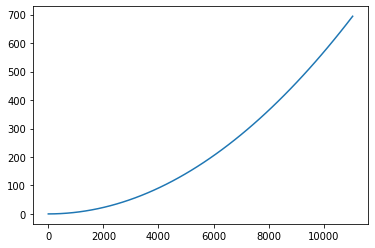

In [95]:
plt.plot(x0, z0)
plt.show()

In [96]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [97]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0

In [98]:
def static_func(Q):
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])
    Z0=np.dot(Re_b(Ret),tau_force[:3])
#     Z1 = d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None)).T
    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)

    Z1 = d_s(ne, x, y, z, Ret, test).T
    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
    
############################################################ 
    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T

############################################################    

    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    C3=d_me(φ,θ,ψ,Ret,  ωe,ωe(φ,θ,ψ,None,None))
    B_ =C3
    B=(B_ + C0.squeeze()
      )

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans  

In [99]:
q0

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [100]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [101]:
root

array([ 6.20781514e-01,  2.25660496e+02,  4.51487595e+02,  6.78101204e+02,
        9.02880012e+02,  1.12844501e+03,  1.35401001e+03,  1.57957500e+03,
        1.80514000e+03,  2.03070500e+03,  2.25626999e+03,  2.48183499e+03,
        2.70739999e+03,  2.93296498e+03,  3.15852998e+03,  3.38409498e+03,
        3.60965997e+03,  3.83522497e+03,  4.06078997e+03,  4.28635496e+03,
        4.51191996e+03,  4.73748496e+03,  4.96304996e+03,  5.18861495e+03,
        5.41417995e+03,  5.63974495e+03,  5.86530994e+03,  6.09087494e+03,
        6.31643994e+03,  6.54200493e+03,  6.76756993e+03,  6.99313493e+03,
        7.21869992e+03,  7.44426492e+03,  7.66982992e+03,  7.89539491e+03,
        8.12095991e+03,  8.34652491e+03,  8.57208990e+03,  8.79765490e+03,
        9.02321990e+03,  9.24878490e+03,  9.47434989e+03,  9.69991489e+03,
        9.92547989e+03,  1.01510449e+04,  1.03766099e+04,  1.06021749e+04,
        1.08277399e+04,  1.10533049e+04, -1.37673236e-16, -1.37673236e-16,
       -1.37673236e-16, -

In [102]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [103]:
x0

[0.0,
 225.56499682574736,
 451.1299936514947,
 676.6949904772421,
 902.2599873029894,
 1127.8249841287368,
 1353.3899809544841,
 1578.9549777802315,
 1804.5199746059789,
 2030.0849714317262,
 2255.6499682574736,
 2481.2149650832207,
 2706.7799619089683,
 2932.344958734716,
 3157.909955560463,
 3383.47495238621,
 3609.0399492119577,
 3834.6049460377053,
 4060.1699428634524,
 4285.7349396892,
 4511.299936514947,
 4736.864933340695,
 4962.429930166441,
 5187.994926992189,
 5413.559923817937,
 5639.124920643684,
 5864.689917469432,
 6090.254914295178,
 6315.819911120926,
 6541.384907946674,
 6766.94990477242,
 6992.514901598168,
 7218.079898423915,
 7443.644895249663,
 7669.209892075411,
 7894.774888901157,
 8120.339885726905,
 8345.904882552652,
 8571.4698793784,
 8797.034876204147,
 9022.599873029894,
 9248.164869855642,
 9473.72986668139,
 9699.294863507137,
 9924.859860332883,
 10150.42485715863,
 10375.989853984378,
 10601.554850810126,
 10827.119847635873,
 11052.68484446162]

In [104]:
x0_

array([6.20781514e-01, 2.25660496e+02, 4.51487595e+02, 6.78101204e+02,
       9.02880012e+02, 1.12844501e+03, 1.35401001e+03, 1.57957500e+03,
       1.80514000e+03, 2.03070500e+03, 2.25626999e+03, 2.48183499e+03,
       2.70739999e+03, 2.93296498e+03, 3.15852998e+03, 3.38409498e+03,
       3.60965997e+03, 3.83522497e+03, 4.06078997e+03, 4.28635496e+03,
       4.51191996e+03, 4.73748496e+03, 4.96304996e+03, 5.18861495e+03,
       5.41417995e+03, 5.63974495e+03, 5.86530994e+03, 6.09087494e+03,
       6.31643994e+03, 6.54200493e+03, 6.76756993e+03, 6.99313493e+03,
       7.21869992e+03, 7.44426492e+03, 7.66982992e+03, 7.89539491e+03,
       8.12095991e+03, 8.34652491e+03, 8.57208990e+03, 8.79765490e+03,
       9.02321990e+03, 9.24878490e+03, 9.47434989e+03, 9.69991489e+03,
       9.92547989e+03, 1.01510449e+04, 1.03766099e+04, 1.06021749e+04,
       1.08277399e+04, 1.10533049e+04])

In [105]:
z0

[0.0,
 0.2888428427924309,
 1.155373265710624,
 2.5995969523577234,
 4.621523375418674,
 7.221165796797117,
 10.398541267595833,
 14.15367062831231,
 18.486578508975636,
 23.39729332924428,
 28.885847298621222,
 34.95227641670818,
 41.59662047340119,
 48.81892304912524,
 56.619231515186364,
 64.99759703402582,
 73.9540745596112,
 83.48872283771031,
 93.60160440638002,
 104.29278559627915,
 115.56233653119654,
 127.41033112846175,
 139.83684709937523,
 152.8419659498538,
 166.4257729808412,
 180.58835728891447,
 195.3298117668901,
 210.65023310439128,
 226.54972178849314,
 243.02838210444648,
 260.0863221362252,
 277.72365376736735,
 295.94049268164,
 314.7369583638412,
 334.1131741005232,
 354.0692669808534,
 374.60536789741576,
 395.72161154711085,
 417.41813643197673,
 439.6950848601867,
 462.5526029468705,
 485.9908406151509,
 510.0099515971214,
 534.6100934348437,
 559.7914274813454,
 585.5541189017534,
 611.8983366742727,
 638.8242535914375,
 666.3320462610891,
 694.4218951076863]

In [106]:
z0_

array([6.83794572e-05, 2.88911204e-01, 1.15544150e+00, 2.59966484e+00,
       4.62159056e+00, 7.22123174e+00, 1.03986052e+01, 1.41537314e+01,
       1.84866348e+01, 2.33973434e+01, 2.88858895e+01, 3.49523093e+01,
       4.15966432e+01, 4.88189355e+01, 5.66192342e+01, 6.49975912e+01,
       7.39540615e+01, 8.34887040e+01, 9.36015812e+01, 1.04292759e+02,
       1.15562308e+02, 1.27410301e+02, 1.39836817e+02, 1.52841935e+02,
       1.66425743e+02, 1.80588328e+02, 1.95329783e+02, 2.10650206e+02,
       2.26549696e+02, 2.43028357e+02, 2.60086299e+02, 2.77723632e+02,
       2.95940472e+02, 3.14736939e+02, 3.34113156e+02, 3.54069250e+02,
       3.74605353e+02, 3.95721598e+02, 4.17418124e+02, 4.39695074e+02,
       4.62552593e+02, 4.85990832e+02, 5.10009944e+02, 5.34610087e+02,
       5.59791423e+02, 5.85554115e+02, 6.11898334e+02, 6.38824252e+02,
       6.66332046e+02, 6.94421896e+02])

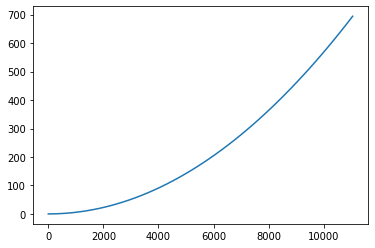

In [107]:
plt.plot(x0_, z0_)
plt.show()

In [108]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0_

In [109]:
q0

array([6.20781514e-01, 2.25660496e+02, 4.51487595e+02, 6.78101204e+02,
       9.02880012e+02, 1.12844501e+03, 1.35401001e+03, 1.57957500e+03,
       1.80514000e+03, 2.03070500e+03, 2.25626999e+03, 2.48183499e+03,
       2.70739999e+03, 2.93296498e+03, 3.15852998e+03, 3.38409498e+03,
       3.60965997e+03, 3.83522497e+03, 4.06078997e+03, 4.28635496e+03,
       4.51191996e+03, 4.73748496e+03, 4.96304996e+03, 5.18861495e+03,
       5.41417995e+03, 5.63974495e+03, 5.86530994e+03, 6.09087494e+03,
       6.31643994e+03, 6.54200493e+03, 6.76756993e+03, 6.99313493e+03,
       7.21869992e+03, 7.44426492e+03, 7.66982992e+03, 7.89539491e+03,
       8.12095991e+03, 8.34652491e+03, 8.57208990e+03, 8.79765490e+03,
       9.02321990e+03, 9.24878490e+03, 9.47434989e+03, 9.69991489e+03,
       9.92547989e+03, 1.01510449e+04, 1.03766099e+04, 1.06021749e+04,
       1.08277399e+04, 1.10533049e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

### Vessle Simulation

In [110]:
sampleTime = 0.01              # sample time [seconds]
N = 5000                      # number of samples

In [111]:
vehicle=semisub('DPcontrol',2,2,40.0,0,0) 

In [112]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [113]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

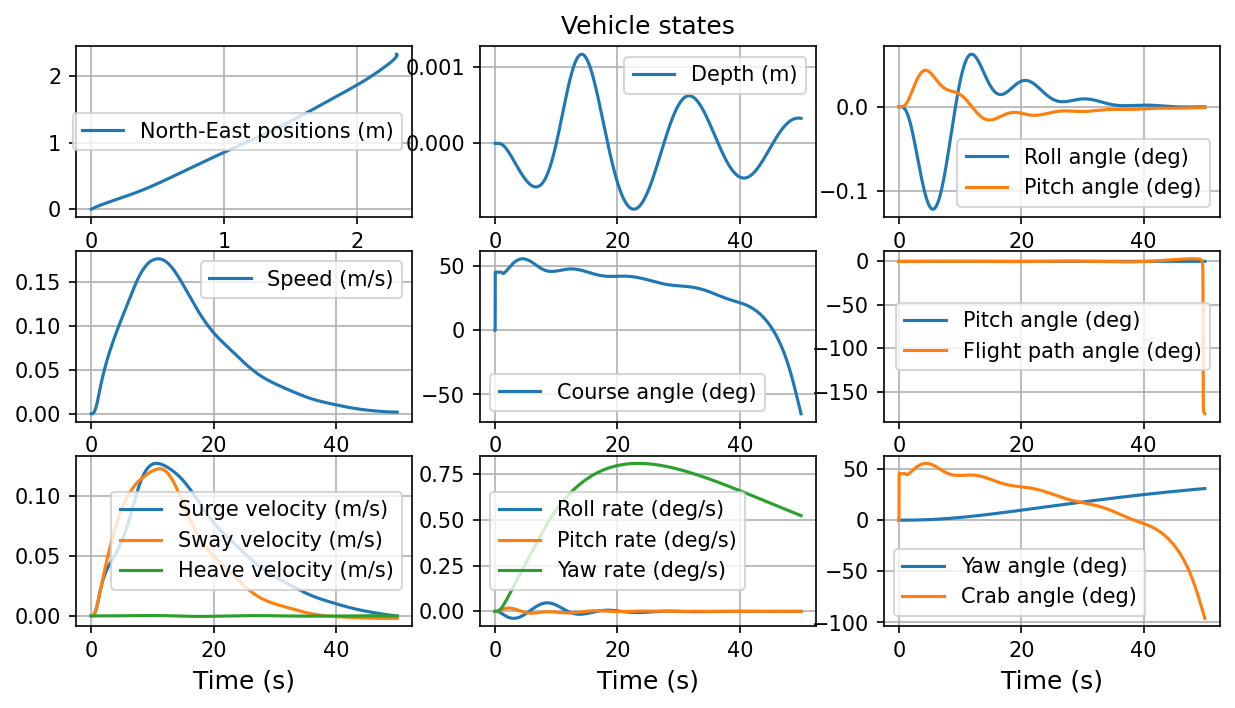

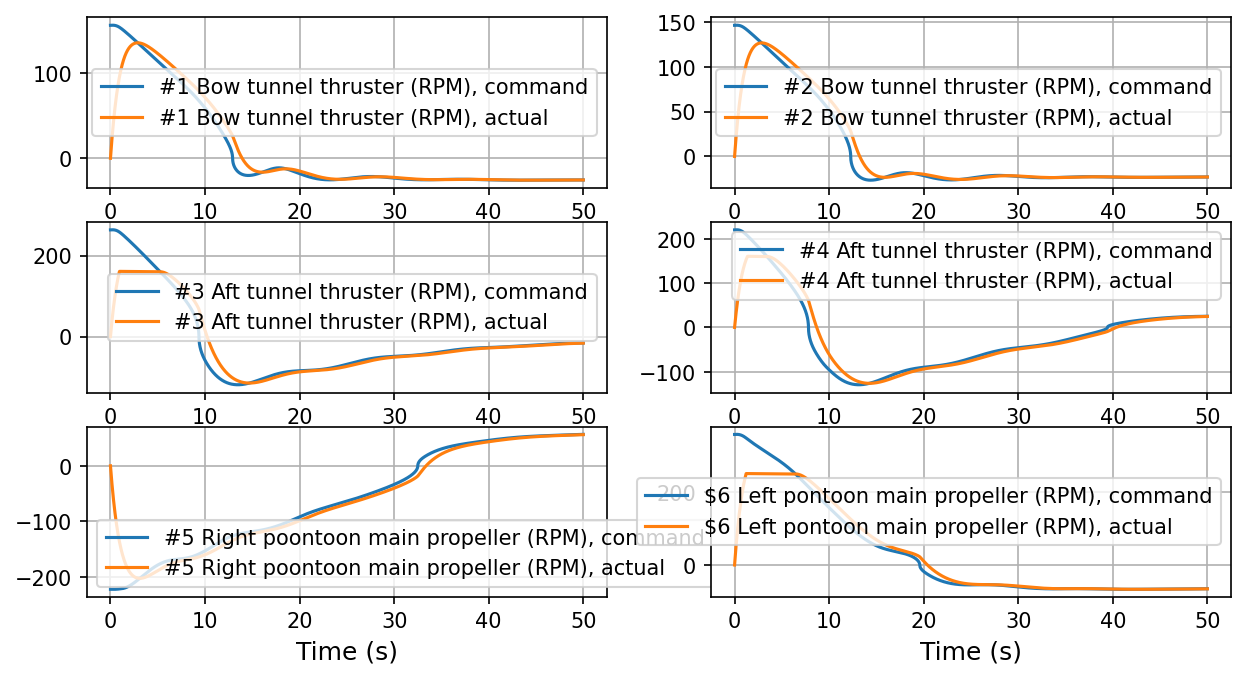

In [114]:
plotVehicleStates(simTime, simData, 1)                    
plotControls(simTime, simData, vehicle, 2)

In [115]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'       

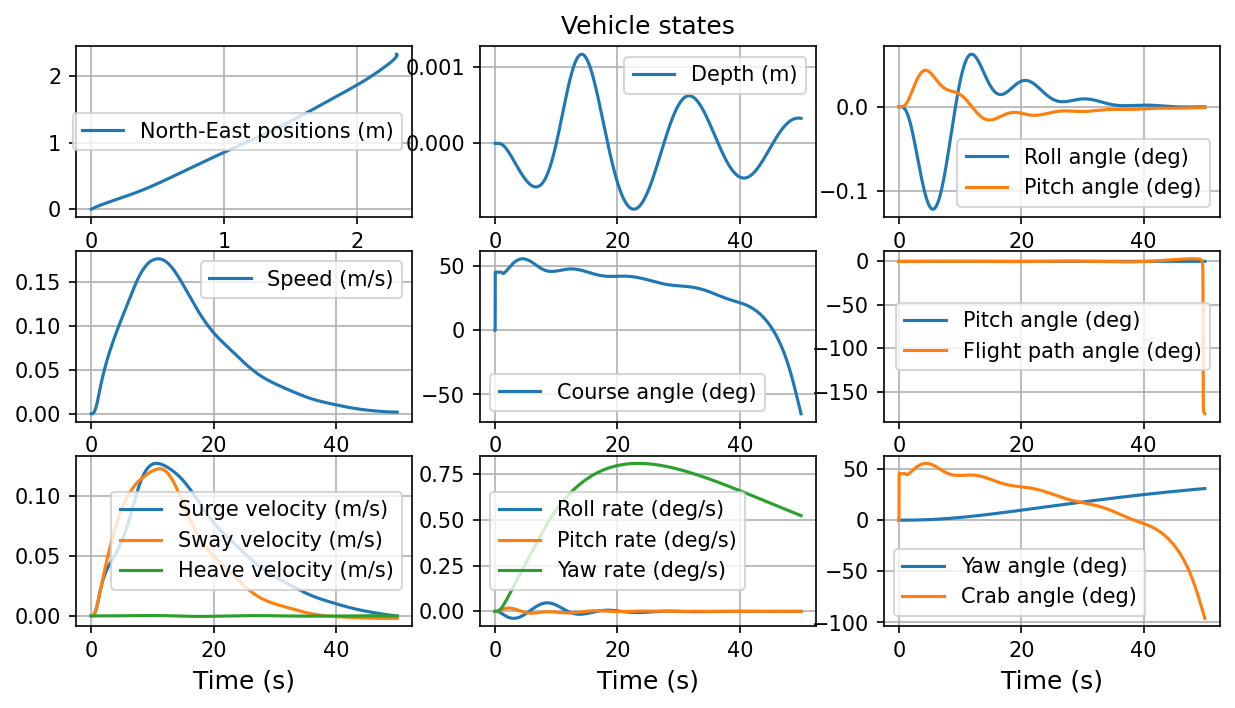

In [116]:
plotVehicleStates(simTime, simData, 3)

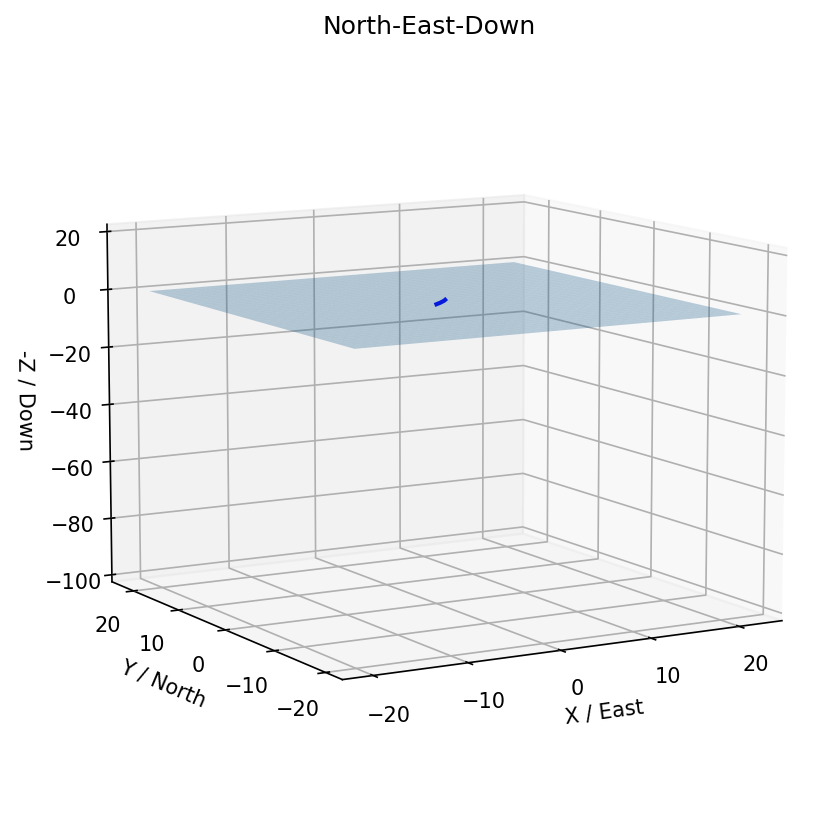

In [117]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

In [118]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

### Dynamics

In [119]:
def grayscott1d(t, Q):
    print(t)
      
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    
    idx = find_nearest(np.array(ans_t),  t) 

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])
    
    
    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]
    
    
    η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])
    
    dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
    
    n_ = vehicle.DPcontrol(η,dη,sampleTime) # /1e3
    

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
    Ret = Re_t(φ,θ,ψ)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
#     force_schedule =1/(1+np.exp(-np.exp(t/10)+np.exp(2)))
    force_schedule = t/15 if t<15 else 1
#     force_schedule = 1
    tau_force = force_schedule*0.0166666667*n_ # [N]

    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)
    
    Z0=np.dot(Re_b(Ret),tau_force[:3])   
    Z1 =d_s(ne, x, y, z, Ret, test).T
#     Z1 =d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T
#     print(Z1)
    Z2=ne_(dx,dy,dz,DT,Ret).T

    Z= (Z1 + Z2 +Z0)

############################################################    

    RRRR=Re_b(Ret)
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',
                                             [Ws[i] for i in range(node_N-1)]
                                             +[vessel_mass]
                                             ,RRRR),
                                   Z).T 
############################################################      

    
 
    
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float32).T))

    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe, ωe(φ,θ,ψ,None,None))
    
#     C4= np.cross(d_s(phi,x,y,z,Ret, phi(x,y,z,Ret,None)).T, ne(x,y,z,Ret, phi(x,y,z,Ret,None)))
#     C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None)).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None)))

    C4= np.cross(d_s(phi,x,y,z,Ret, test).T, ne(x,y,z,Ret, test))
    
    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float32).T)

    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0.squeeze()
       

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)

    A=np.einsum('ijk,ikr->ijr',A2,A3)

############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################


#     ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
#     print(A1111)
    return A1111

In [120]:
tspan = (0., 5)

In [ ]:
startTime1 = datetime.now()

us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
print(datetime.now() - startTime1)

0.0
0.00010444055243823689
0.002088811048764738
0.003133216573147107
0.008355244195058951
0.009283604661176613
0.01044405524382369
0.01044405524382369
0.03133216573147107
0.04177622097529476
0.09399649719441322
0.10328010185558982
0.11488460768206059
0.11488460768206059
0.32376571255853437
0.4282062649967713
0.9504090271879557
1.0432450737997219
1.1592901320644295
1.1592901320644295
1.3973169409043407
1.5163303453242962
2.1113973674240745
2.2171870602418124
2.3494241762639856
2.3494241762639856
1.283931312447913
1.3462519026396549
1.657854853598364
1.7132509337688009
1.7824960339818474
1.7824960339818474
1.901182537511932
1.9605257892769743
2.2572420481021855
2.3099916052266676
2.37592855163227
2.37592855163227
1.844648868383511
1.8757252855843427
2.0311073715885013
2.0587308535447963
2.093260205990165
2.093260205990165
2.1554130403918283
2.18648945759266
2.3418715435968185
2.3694950255531135
2.404024377998482
2.404024377998482
2.141964920186619
2.166317277284846
2.288079062775982
2.30

2.9443586107076767
2.9446417429141443
2.9449956581722283
2.9449956581722283
2.945713422517494
2.9460723046901265
2.94786671555329
2.9481857219289633
2.9485844798985554
2.9485844798985554
2.9453192653803097
2.9454810689843507
2.946290087004554
2.946433912430368
2.9466136942126355
2.9466136942126355
2.946937301420717
2.9470991050247575
2.9479081230449613
2.9480519484707752
2.9482317302530427
2.9482317302530427
2.9488166967901988
2.9491091800587768
2.9505715964016668
2.950831581529292
2.951156562938823
2.951156562938823
2.9517974745069546
2.952117930291021
2.953720209211351
2.954005058797187
2.954361120779483
2.954361120779483
2.951442386644605
2.9515852984974957
2.9522998577619513
2.952426890520077
2.9525856814677334
2.9525856814677334
2.9528715051735155
2.9530144170264068
2.953728976290862
2.9538560090489874
2.954014799996644
2.954014799996644
2.9545844898218863
2.9548693347345076
2.956293559297614
2.9565467547754993
2.9568632491228564
2.9568632491228564
2.957511869549379
2.957836179762

3.0206680310369727
3.0207390152462676
3.0208277455078862
3.0208277455078862
3.0209874599788
3.0210673172142566
3.0214666033915405
3.0215375876008355
3.021626317862454
3.021626317862454
3.021896906319697
3.0220322005483182
3.0227086716914253
3.0228289332279776
3.0229792601486682
3.0229792601486682
3.02326862486216
3.023413307218906
3.024136719002636
3.0242653255419656
3.024426083716128
3.024426083716128
3.0231088307416756
3.023173616038179
3.0234975425206967
3.0235551294509224
3.023627113113704
3.023627113113704
3.0237566837067114
3.023821469003215
3.0241453954857325
3.024202982415958
3.02427496607874
3.02427496607874
3.0245578428443833
3.0246992812272047
3.025406473141313
3.0255321961482657
3.0256893499069566
3.0256893499069566
3.026023786276813
3.0261910044617406
3.027027095386381
3.027175733772984
3.0273615317562372
3.0273615317562372
3.0258399169632164
3.0259152004913465
3.0262916181319968
3.026358536823668
3.0264421851882566
3.0264421851882566
3.0265927522445164
3.0266680357726465


3.0638342653497848
3.063914028700512
3.0640137328889216
3.0640137328889216
3.06420831895797
3.064305611992494
3.064792077165115
3.06487855986247
3.0649866632341634
3.0649866632341634
3.0640998428794397
3.0641428978746985
3.0643581728509934
3.0643964439578903
3.0644442828415115
3.0644442828415115
3.0645303928320295
3.0645734478272884
3.0647887228035833
3.06482699391048
3.0648748327941013
3.0648748327941013
3.0650635112082067
3.0651578504152592
3.0656295464505225
3.0657134035234583
3.065818224864628
3.065818224864628
3.0660413902452612
3.066152972935578
3.0667108863871615
3.066810071000776
3.0669340517677948
3.0669340517677948
3.0659186930225313
3.065968927101483
3.0662200974962412
3.066264750010865
3.0663205656541446
3.0663205656541446
3.066421033812048
3.0664712678909996
3.066722438285758
3.0667670908003815
3.066822906443661
3.066822906443661
3.066993581834053
3.067078919529249
3.067505608005229
3.067581463734292
3.067676283395621
3.067676283395621
3.06786027289744
3.0679522676483497
3

3.0932274228805428
3.0932634402162407
3.0932634402162407
3.0933282714204973
3.093360687022625
3.093522765033266
3.093551578901825
3.0935875962375228
3.0935875962375228
3.09373001927861
3.093801230799154
3.094157288401872
3.0942205875312445
3.0942997114429596
3.0942997114429596
3.0944677152274087
3.0945517171196335
3.0949717265807566
3.0950463949294007
3.0951397303652057
3.0951397303652057
3.0943752227213754
3.0944129783605834
3.0946017565566226
3.0946353171248075
3.0946772678350385
3.0946772678350385
3.0947527791134544
3.0947905347526623
3.0949793129487015
3.0950128735168865
3.0950548242271174
3.0950548242271174
3.0951821188073336
3.0952457660974413
3.0955640025479814
3.0956205779169665
3.0956912971281976
3.0956912971281976
3.095828904981993
3.095897708908891
3.09624172854338
3.096302887589511
3.096379336397175
3.096379336397175
3.0957555254135647
3.0957876395562485
3.095948210269667
3.0959767561742746
3.096012438555034
3.096012438555034
3.096076666840401
3.096108780983085
3.0962693516

3.116926202511452
3.116985641939534
3.117059941224637
3.117059941224637
3.116451467785991
3.116481577849631
3.116632128167833
3.1166588926688465
3.1166923482951137
3.1166923482951137
3.1167525684223945
3.1167826784860346
3.1169332288042364
3.11695999330525
3.116993448931517
3.116993448931517
3.117096179445934
3.1171475447031427
3.1174043709891848
3.1174500289955924
3.1175071015036018
3.1175071015036018
3.117618588219766
3.117674331577848
3.117953048368258
3.1180025980198867
3.118064535084422
3.118064535084422
3.1175584915479266
3.1175841865700895
3.117712661680902
3.117735501700602
3.117764051725227
3.117764051725227
3.117815441769552
3.1178411367917147
3.1179696119025273
3.1179924519222273
3.118021001946852
3.118021001946852
3.118129518031372
3.118183776073632
3.1184550662849317
3.1185032956558296
3.1185635823694517
3.1185635823694517
3.1186918152491216
3.1187559316889564
3.119076513888131
3.1191335062790952
3.119204746767801
3.119204746767801
3.1186210845857705
3.1186498356939296
3.1

3.135081165139892
3.1352991783556683
3.1353379362606955
3.135386383641979
3.135386383641979
3.135481956540578
3.135529742989877
3.135768675236374
3.135811152080196
3.1358642481349728
3.1358642481349728
3.135428831508621
3.135450055441942
3.135556175108547
3.135575040827055
3.135598622975189
3.135598622975189
3.135641070841831
3.1356622947751522
3.135768414441757
3.135787280160265
3.135810862308399
3.135810862308399
3.1359030496789564
3.1359491433642352
3.136179611790629
3.136220583955321
3.1362717991611864
3.1362717991611864
3.1363809008622243
3.1364354517127433
3.1367082059653386
3.136756695610244
3.1368173076663766
3.1368173076663766
3.1363209350922676
3.1363455030578082
3.136468342885512
3.1364901810771033
3.136517478816593
3.136517478816593
3.1365666147476743
3.136591182713215
3.1367140225409185
3.13673586073251
3.1367631584719997
3.1367631584719997
3.1368477499590735
3.1368900457026103
3.137101524420294
3.1371391206367716
3.137186115907368
3.137186115907368
3.1372782501417626
3.13

3.150688483316762
3.1507048798013804
3.150725375407153
3.150725375407153
3.150762267497544
3.1507807135427393
3.150872943768716
3.1508893402533347
3.150909835859107
3.150909835859107
3.150989601388389
3.1510294841530295
3.1512288979762335
3.151264349322581
3.151308663505515
3.151308663505515
3.15140256655249
3.1514495180759776
3.1516842756934147
3.151726010380959
3.1517781787403893
3.1517781787403893
3.151350932577915
3.151372067114115
3.151477739795115
3.151496526049515
3.151520008867515
3.151520008867515
3.151562277939915
3.1515834124761146
3.1516890851571144
3.1517078714115145
3.1517313542295144
3.1517313542295144
3.1518036134368677
3.1518397430405445
3.152020391058928
3.152052506262196
3.1520926502662814
3.1520926502662814
3.1521715135110715
3.152210945133467
3.1524081032454427
3.1524431535764603
3.152486966490233
3.152486966490233
3.152129356572728
3.1521477097259516
3.152239475492068
3.152255789406045
3.152276181798515
3.152276181798515
3.152312888104962
3.152331241258185
3.15242

3.164445713987154
3.1644847622330863
3.164680003462748
3.164714713014688
3.164758099954613
3.164758099954613
3.1644023706159783
3.1644197471763227
3.164506629978045
3.1645220758094625
3.1645413830987343
3.1645413830987343
3.1645761362194236
3.164593512779768
3.1646803955814904
3.164695841412908
3.1647151487021796
3.1647151487021796
3.164782311810175
3.164815893364173
3.164983801134161
3.1650136514043816
3.1650509642421567
3.1650509642421567
3.165127349434271
3.1651655420303277
3.1653565050106125
3.1653904539848856
3.1654328902027267
3.1654328902027267
3.1650849678575397
3.1651019696652307
3.1651869787036877
3.165202091421636
3.1652209823190707
3.1652209823190707
3.1652549859344536
3.1652719877421447
3.1653569967806017
3.16537210949855
3.1653910003959846
3.1653910003959846
3.165457714371854
3.1654910713597886
3.1656578562994615
3.1656875069554036
3.165724570275331
3.165724570275331
3.165801204464187
3.165839521558615
3.1660311070307547
3.166065166670246
3.166107741219611
3.1661077412196

3.176224119373765
3.176224119373765
3.1762847612044482
3.1763150821197903
3.176466686696499
3.176493638621247
3.176527328527182
3.176527328527182
3.176598955993103
3.176634769726064
3.1768138383908675
3.1768456728201655
3.1768854658567887
3.1768854658567887
3.1765594462788855
3.1765755051547373
3.1766557995339966
3.176670074090309
3.1766879172857
3.1766879172857
3.1767200350374036
3.1767360939132554
3.1768163882925147
3.176830662848827
3.176848506044218
3.176848506044218
3.1769065740311992
3.17693560802469
3.1770807779921433
3.177106585986357
3.1771388459791243
3.1771388459791243
3.1772031219448356
3.177235259927691
3.1773959498419684
3.1774245169378403
3.1774602258076796
3.1774602258076796
3.177166574877983
3.177180439327413
3.1772497615745605
3.177262085529609
3.1772774904734193
3.1772774904734193
3.177305219372278
3.177319083821708
3.1773884060688555
3.177400730023904
3.1774161349677144
3.1774161349677144
3.177477693177789
3.177508472282826
3.1776623678080127
3.17768972701249
3.1777

3.186942393217948
3.1869564871453817
3.1869564871453817
3.1869818562147625
3.1869945407494527
3.187057963422905
3.187069238564852
3.1870833324922856
3.1870833324922856
3.187139111065219
3.1871670003516854
3.1873064467840186
3.187331237260878
3.187362225356952
3.187362225356952
3.187428195323089
3.1874611803061574
3.1876261052215003
3.18765542520645
3.187692075187637
3.187692075187637
3.1873918800450487
3.187406707389097
3.1874808441093387
3.1874940239707152
3.1875104987974354
3.1875104987974354
3.187540153485532
3.1875549808295807
3.187629117549822
3.1876422974111986
3.187658772237919
3.187658772237919
3.187709042011157
3.187734176897776
3.187859851330871
3.1878821934523103
3.1879101211041094
3.1879101211041094
3.1879648217178636
3.1879921720247406
3.188128923559126
3.188153234943017
3.18818362417288
3.18818362417288
3.1879358345873294
3.18794869132894
3.1880129750369903
3.1880244032517546
3.1880386885202103
3.1880386885202103
3.1880644020034303
3.1880772587450408
3.1881415424530912
3.

3.196862050085818
3.196884582862649
3.1969127488336877
3.1969127488336877
3.1966826865636375
3.1966944022982866
3.1967529809715325
3.196763394957887
3.1967764124408307
3.1967764124408307
3.196799843910129
3.196811559644778
3.196870138318024
3.1968805523043784
3.196893569787322
3.196893569787322
3.1969427615143755
3.1969673573779023
3.1970903366955365
3.197112199685338
3.19713952842259
3.19713952842259
3.197197696685369
3.1972267808167585
3.197372201473706
3.1973980540349407
3.1974303697364848
3.1974303697364848
3.197165538044677
3.1971785428557205
3.197243566910937
3.197255126742976
3.197269576533024
3.197269576533024
3.1972955861551107
3.197308590966154
3.197373615021371
3.1973851748534097
3.1973996246434577
3.1973996246434577
3.1974473191861805
3.197471166457542
3.19759040281435
3.197611600388893
3.1976380973570726
3.1976380973570726
3.19769109542719
3.1977175944622487
3.1978500896375426
3.1978736443353726
3.19790308770766
3.19790308770766
3.1976611427044275
3.1976726653781053
3.1977

3.205360760076761
3.205372666885227
3.205372666885227
3.205418711623932
3.205441733993285
3.2055568458400474
3.2055773101683607
3.2056028905787524
3.2056028905787524
3.205657231663724
3.20568440220621
3.205820254918639
3.20584440651196
3.205874596003611
3.205874596003611
3.205627350284437
3.205639580137279
3.2057007294014896
3.205711600381794
3.205725189107174
3.205725189107174
3.2057496488128585
3.2057618786657005
3.2058230279299114
3.2058338989102158
3.205847487635596
3.205847487635596
3.2058899892754575
3.205911240095388
3.206017494195042
3.206036383812758
3.2060599958349036
3.2060599958349036
3.2061066370564353
3.206129957667201
3.2062465607210298
3.2062672901528217
3.2062932019425614
3.2062932019425614
3.206081344170377
3.206092018338113
3.2061453891767964
3.2061548773258957
3.2061667375122695
3.2061667375122695
3.2061880858477427
3.2061987600154795
3.2062521308541623
3.2062616190032616
3.2062734791896355
3.2062734791896355
3.2063185168898958
3.2063410357400257
3.2064536299906763


3.213650746116203
3.213650746116203
3.2134378156593164
3.2134482626177308
3.2135004974098043
3.213509783595062
3.213521391326634
3.213521391326634
3.2135422852434634
3.2135527322018778
3.2136049669939513
3.213614253179209
3.213625860910781
3.213625860910781
3.2136668013654877
3.2136872715928413
3.2137896227296086
3.213807818487256
3.2138305631843154
3.2138305631843154
3.2138779182541777
3.213901595789109
3.214019983463765
3.2140410301614817
3.2140673385336274
3.2140673385336274
3.213851337856643
3.213861725192807
3.213913661873627
3.213922895061328
3.2139344365459546
3.2139344365459546
3.2139552112182823
3.2139655985544464
3.214017535235266
3.214026768422967
3.2140383099075938
3.2140383099075938
3.214080442527413
3.214101508837323
3.2142068403868707
3.214225565995679
3.21424897300669
3.21424897300669
3.214297410035503
3.21432162854991
3.2144427211219435
3.214464248690305
3.2144911581507567
3.2144911581507567
3.2142707942456608
3.214281704865146
3.2143362579625725
3.214345956291004
3.21

3.2210273503150835
3.221048432154332
3.221048432154332
3.221090709940412
3.221111848833452
3.2212175432986516
3.2212363334257983
3.2212598210847316
3.2212598210847316
3.2210669182958163
3.221076161366559
3.22112237672027
3.2211305927831515
3.221140862861754
3.221140862861754
3.2211593490032384
3.221168592073981
3.221214807427692
3.2212230234905737
3.2212332935691763
3.2212332935691763
3.221272526820803
3.2212921434466164
3.221390226575683
3.221407663576406
3.2214294598273097
3.2214294598273097
3.2214756370888757
3.221498725719659
3.221614168873574
3.221634692100937
3.22166034613514
3.22166034613514
3.2214502333794903
3.2214606201555807
3.2215125540360323
3.2215217867258903
3.221533327588213
3.221533327588213
3.2215541011403936
3.221564487916484
3.2216164217969356
3.2216256544867936
3.2216371953491163
3.2216371953491163
3.2216737606207366
3.221692043256547
3.221783456435598
3.2217997076674294
3.2218200217072184
3.2218200217072184
3.221860360398025
3.2218805297434288
3.2219813764704464
3

3.227872636739684
3.2278908829398314
3.227900006039905
3.227945621540273
3.2279537309625606
3.2279638677404203
3.2279638677404203
3.227999244589972
3.2280169330147475
3.2281053751386266
3.228121098182872
3.228140751988178
3.228140751988178
3.228181571158799
3.22820198074411
3.228304028670663
3.228322170524272
3.2283448478412837
3.2283448478412837
3.228158508011665
3.2281673860234084
3.2282117760821256
3.2282196676481196
3.2282295321056123
3.2282295321056123
3.228247288129099
3.2282561661408424
3.2283005561995597
3.2283084477655537
3.2283183122230463
3.2283183122230463
3.228355346626126
3.2283738638276662
3.228466449835366
3.228482909570068
3.2285034842384457
3.2285034842384457
3.228546352983152
3.228567787355505
3.2286749592172717
3.2286940119926966
3.228717827961978
3.228717827961978
3.228522753181108
3.2285323876524394
3.228580560009096
3.2285891239836126
3.2285998289517583
3.2285998289517583
3.2286190978944207
3.228628732365752
3.2286769047224086
3.2286854686969253
3.228696173665071

3.234440209383629
3.234440209383629
3.2344802779787196
3.234500312276265
3.2346004837639915
3.2346182920284763
3.234640552359082
3.234640552359082
3.23445813200972
3.2344670933227655
3.2345118998879934
3.2345198654995895
3.2345298225140846
3.2345298225140846
3.234547745140176
3.2345567064532212
3.234601513018449
3.234609478630045
3.2346194356445404
3.2346194356445404
3.2346524062088795
3.234668891491049
3.2347513179018965
3.2347659714860475
3.2347842884662357
3.2347842884662357
3.2348210910600517
3.2348394923569592
3.2349314988414988
3.2349478555498616
3.2349683014353148
3.2349683014353148
3.2348002021752884
3.234808159029815
3.234847943302447
3.234855016062026
3.2348638570115
3.2348638570115
3.2348797707205525
3.234887727575079
3.234927511847711
3.23493458460729
3.234943425556764
3.234943425556764
3.2349781404822524
3.234995497944997
3.2350822852587178
3.2350977141144903
3.2351170001842062
3.2351170001842062
3.2351579959400607
3.2351784938179877
3.2352809832076233
3.235299203543559
3.

3.240454990984582
3.240472040138059
3.240480564714798
3.2405231875984906
3.240530765000036
3.2405402367519676
3.2405402367519676
3.2405711603040914
3.2405866220801536
3.240663930960464
3.240677674761408
3.2406948545125878
3.2406948545125878
3.240729190758244
3.2407463588810717
3.240832199495211
3.2408474600488364
3.2408665357408672
3.2408665357408672
3.2407097166145236
3.2407171476654915
3.2407543029203314
3.2407609082989697
3.240769165022267
3.240769165022267
3.240784027124203
3.240791458175171
3.240828613430011
3.240835218808649
3.2408434755319466
3.2408434755319466
3.2408762946630754
3.2408927042286395
3.2409747520564616
3.2409893383369632
3.2410075711875903
3.2410075711875903
3.2410464579988494
3.2410659014044794
3.2411631184326275
3.2411804014598538
3.2412020052438866
3.2412020052438866
3.241025011938923
3.2410337323145892
3.241077334192921
3.2410850856379576
3.2410947749442536
3.2410947749442536
3.241112215695586
3.2411209360712525
3.2411645379495844
3.241172289394621
3.241181978

3.246464101919947
3.246464101919947
3.2463007534087276
3.246308802046063
3.246349045232739
3.2463561995770367
3.246365142507409
3.246365142507409
3.246381239782079
3.2463892884194143
3.2464295316060903
3.246436685950388
3.2464456288807604
3.2464456288807604
3.2464746760964336
3.2464891997042704
3.246561817743453
3.2465747276170855
3.2465908649591264
3.2465908649591264
3.2466231414098754
3.2466392796352497
3.2467199707621215
3.2467343158513433
3.2467522472128705
3.2467522472128705
3.246605020019811
3.2466120975501536
3.246647485201865
3.2466537763399472
3.2466616402625497
3.2466616402625497
3.246675795323234
3.246682872853577
3.2467182605052884
3.2467245516433705
3.246732415565973
3.246732415565973
3.2467632497356065
3.246778666820423
3.2468557522445063
3.246869456319899
3.24688658641414
3.24688658641414
3.246923052235384
3.246941285146006
3.2470324496991156
3.2470486567307795
3.2470689155203596
3.2470689155203596
3.2469029594559218
3.2469111459768123
3.2469520785812667
3.24695935548872

3.251725888588662
3.2517543856165565
3.251768634130504
3.2518398767002403
3.251852542045971
3.2518683737281346
3.2518683737281346
3.251900391926113
3.251916401025102
3.2519964465200477
3.25201067683026
3.252028464718026
3.252028464718026
3.2518826508718
3.251889789443633
3.2519254823027968
3.2519318276999813
3.2519397594464623
3.2519397594464623
3.251954036590128
3.2519611751619606
3.2519968680211244
3.252003213418309
3.25201114516479
3.25201114516479
3.252039297640409
3.2520533738782187
3.252123755067267
3.252136267278653
3.252151907542886
3.252151907542886
3.252184542342404
3.2522008597421626
3.252282446740957
3.252296951096298
3.2523150815404747
3.2523150815404747
3.2521662508708324
3.2521734225348053
3.2522092808546708
3.2522156556670914
3.252223624182617
3.252223624182617
3.2522379675105633
3.252245139174536
3.2522809974944016
3.252287372306822
3.252295340822348
3.252295340822348
3.252324164555878
3.252338576422643
3.2524106357564677
3.2524234463047033
3.252439459489998
3.25243945

3.2569100327395923
3.2569165046090403
3.2569488639562816
3.2569546167291246
3.2569618076951783
3.2569618076951783
3.256974751434075
3.256981223303523
3.2570135826507642
3.257019335423607
3.257026526389661
3.257026526389661
3.2570540336852583
3.257067787333057
3.2571365555720506
3.2571487810367605
3.257164062867648
3.257164062867648
3.2571965603408146
3.257212809077398
3.2572940527603147
3.257308496081722
3.2573265502334814
3.2573265502334814
3.257178638133144
3.2571859257658913
3.2572223639296305
3.2572288418254067
3.2572369391951264
3.2572369391951264
3.257251514460622
3.2572588020933697
3.257295240257109
3.257301718152885
3.257309815522605
3.257309815522605
3.257335842955066
3.2573488566712965
3.2574139252524494
3.25742549300021
3.2574399526849107
3.2574399526849107
3.2574687413619268
3.257483135700435
3.2575551073929754
3.257567902360538
3.2575838960699914
3.2575838960699914
3.2574527018987975
3.257459076505741
3.2574909495404585
3.2574966158577414
3.2575036987543453
3.2575036987543

3.2618372539456146
3.261850396401299
3.26191610867972
3.2619277908625506
3.2619423935910885
3.2619423935910885
3.261973251308499
3.261988680167205
3.262065824460732
3.262079539001803
3.2620966821781425
3.2620966821781425
3.2619562357110343
3.261963156771007
3.261997762070871
3.2620039141241803
3.2620116041908167
3.2620116041908167
3.2620254463107625
3.262032367370735
3.262066972670599
3.2620731247239085
3.262080814790545
3.262080814790545
3.26210564984062
3.2621180673656576
3.262180154990845
3.2621911927908784
3.26220499004092
3.26220499004092
3.262232590047734
3.262246390051141
3.262315390068176
3.262327656737871
3.26234299007499
3.26234299007499
3.262217244147059
3.2622233712001285
3.2622540064654757
3.262259452734871
3.262266260571615
3.262266260571615
3.262278514677754
3.2622846417308233
3.2623152769961705
3.262320723265566
3.2623275311023097
3.2623275311023097
3.262353891144901
3.2623670711661967
3.2624329712726756
3.262444686847161
3.262459331315267
3.262459331315267
3.2624904597

3.266591375595016
3.266622441826223
3.266627964711771
3.266634868318706
3.266634868318706
3.2666598449081756
3.2666723332029104
3.2667347746765842
3.266745875383015
3.266759751266054
3.266759751266054
3.266788511699121
3.266802891915655
3.266874792998323
3.2668875754130196
3.26690355343139
3.26690355343139
3.2667726430921373
3.2667790890051793
3.2668113185703884
3.26681704827087
3.266824210396472
3.266824210396472
3.2668371022225555
3.2668435481355975
3.2668757777008066
3.2668815074012882
3.26688866952689
3.26688866952689
3.2669125688743703
3.26692451854811
3.2669842669168103
3.2669948888490237
3.2670081662642905
3.2670081662642905
3.2670352035386365
3.2670487221758093
3.267116315361674
3.26712833192805
3.26714335263602
3.26714335263602
3.267019962721799
3.2670258609505534
3.2670553520943253
3.267060594964329
3.267067148551834
3.267067148551834
3.2670789450093425
3.267084843238097
3.2671143343818687
3.2671195772518726
3.2671261308393773
3.2671261308393773
3.2671515878140474
3.267164316

3.2711627386364936
3.2712337876304436
3.2712464185627015
3.2712622072280237
3.2712622072280237
3.27113283381384
3.2711391961006986
3.2711710075349902
3.2711766629010866
3.2711837321087067
3.2711837321087067
3.271196456682423
3.271202818969282
3.2712346304035735
3.27124028576967
3.27124735497729
3.27124735497729
3.271270149525625
3.271281546799793
3.2713385331706313
3.2713486640810023
3.2713613277189664
3.2713613277189664
3.27138654895247
3.2713991595692216
3.2714622126529807
3.2714734220900934
3.271487433886484
3.271487433886484
3.2713724420592665
3.2713779992294163
3.271405785080166
3.271410724786966
3.271416899420466
3.271416899420466
3.271428013760766
3.271433570930916
3.2714613567816655
3.2714662964884655
3.2714724711219656
3.2714724711219656
3.2714966367326586
3.271508719538005
3.271569133564738
3.271579873836157
3.271593299175431
3.271593299175431
3.271621922770512
3.271636234568053
3.271707793555756
3.2717205151535698
3.271736417150837
3.271736417150837
3.2716061202838707
3.2716

3.2754120505486557
3.2754173729259715
3.2754240258976157
3.2754240258976157
3.2754464503020957
3.2754576625043357
3.275513723515535
3.2755236899175264
3.275536147920015
3.275536147920015
3.275561255859572
3.2755738098293508
3.275636579678243
3.2756477387624905
3.2756616876178
3.2756616876178
3.2755471903773774
3.2755527116060588
3.275580317749465
3.275585225508293
3.2755913602068274
3.2755913602068274
3.2756024026641897
3.275607923892871
3.2756355300362774
3.275640437795105
3.2756465724936397
3.2756465724936397
3.275669449181254
3.2756808875250614
3.2757380792440975
3.275748246660815
3.275760955931712
3.275760955931712
3.2757877633828856
3.2758011671084724
3.2758681857364063
3.27588010015915
3.27589499318758
3.27589499318758
3.2757729398962563
3.2757789318785284
3.2758088917898895
3.2758142179963534
3.275820875754434
3.275820875754434
3.275832859718978
3.27583885170125
3.2758688116126113
3.275874137819075
3.2758807955771556
3.2758807955771556
3.2759027733130806
3.275913762181043
3.2759

3.2795751453826703
3.2795865946948184
3.2796438412555586
3.2796540184219127
3.279666739879855
3.279666739879855
3.27956264262109
3.2795678405524478
3.279593830209237
3.2795984505926667
3.279604226071953
3.279604226071953
3.279614621934669
3.279619819866027
3.2796458095228163
3.279650429906246
3.2796562053855323
3.2796562053855323
3.2796782464538694
3.279689266988038
3.279744369658881
3.279754165689253
3.279766410727218
3.279766410727218
3.2797924804976977
3.2798055153829373
3.2798706898091363
3.279882276373794
3.279896759579616
3.279896759579616
3.279778054980675
3.2797838771074037
3.279812987741047
3.2798181629648053
3.279824631994504
3.279824631994504
3.279836276247961
3.2798420983746897
3.279871209008333
3.2798763842320913
3.27988285326179
3.27988285326179
3.2799039670697203
3.2799145239736855
3.2799673084935113
3.2799766924081473
3.2799884223014417
3.2799884223014417
3.2800118656923893
3.280023587387863
3.2800821958652326
3.280092615150098
3.2801056392561803
3.2801056392561803
3.27

3.283480698991668
3.2835058313024126
3.2835102992687673
3.2835158842267105
3.2835158842267105
3.2835373466719164
3.2835480778945194
3.2836017340075347
3.2836112728720708
3.2836231964527407
3.2836231964527407
3.2836484923585596
3.283661140311469
3.2837243800760163
3.2837356227008248
3.283749675981835
3.283749675981835
3.283634496890697
3.2836401471096752
3.2836683982045662
3.2836734206214357
3.2836796986425227
3.2836796986425227
3.2836909990804792
3.2836966492994573
3.2837249003943483
3.283729922811218
3.2837362008323048
3.2837362008323048
3.283756284468439
3.283766326286506
3.283816535376842
3.283825461437346
3.283836619012976
3.283836619012976
3.28385885010537
3.283869965651567
3.283925543382552
3.2839354238680603
3.283947774474946
3.283947774474946
3.283846592092482
3.2838515786322358
3.283876511331002
3.2838809438107823
3.283886484410508
3.283886484410508
3.2838964574900142
3.283901444029768
3.283926376728534
3.2839308092083144
3.28393634980804
3.28393634980804
3.283957632346965
3.2

3.2873770586460624
3.287437483151383
3.287448225285662
3.2874616529535112
3.2874616529535112
3.2873515629307155
3.287356942424638
3.2873838398942508
3.287388621666626
3.287394598882096
3.287394598882096
3.287405357869941
3.2874107373638637
3.287437634833476
3.2874424166058516
3.2874483938213213
3.2874483938213213
3.2874681856688737
3.28747808159265
3.287527561211532
3.2875363575882215
3.287547353059084
3.287547353059084
3.28756941560836
3.287580446882998
3.2876356032561875
3.2876454088336438
3.2876576658054635
3.2876576658054635
3.287556871666269
3.2875616309698614
3.287585427487824
3.2875896579799058
3.2875949460950085
3.2875949460950085
3.287604464702193
3.2876092240057857
3.287633020523748
3.28763725101583
3.2876425391309327
3.2876425391309327
3.287663362542683
3.287673774248558
3.2877258327779337
3.287735087627601
3.287746656189684
3.287746656189684
3.2877712945993323
3.2877836138041565
3.287845209828277
3.2878561602325647
3.287869848237925
3.287869848237925
3.2877576019505486
3.28

3.29103905745069
3.29103905745069
3.2910577053627423
3.2910670293187687
3.2911136490988997
3.291121937059812
3.291132297010952
3.291132297010952
3.2911528188666237
3.29116307979446
3.2912143844336397
3.2912235052583827
3.2912349062893114
3.2912349062893114
3.2911416061059127
3.2911462606533934
3.2911695333907955
3.2911736707663337
3.291178842485756
3.291178842485756
3.291188151580717
3.2911928061281976
3.2912160788655997
3.291220216241138
3.2912253879605604
3.2912253879605604
3.2912451156328895
3.291254979469054
3.2913042986498775
3.291313066504246
3.2913240263222066
3.2913240263222066
3.291347362421692
3.291359030471434
3.2914173707201475
3.2914277423199185
3.2914407068196327
3.2914407068196327
3.291334402663132
3.291339590833595
3.2913655316859094
3.2913701433929874
3.291375908026835
3.291375908026835
3.2913862843677606
3.2913914725382236
3.291417413390538
3.291422025097616
3.2914277897314634
3.2914277897314634
3.2914468111344024
3.291456321835872
3.2915038753432193
3.291512329300081

3.294700657079453
3.294700657079453
3.2946073068811117
3.2946117383027786
3.294633895411114
3.2946378344525957
3.294642758254448
3.294642758254448
3.2946516210977825
3.2946560525194495
3.2946782096277847
3.2946821486692666
3.294687072471119
3.294687072471119
3.294706546434739
3.294716283416549
3.2947649683255986
3.2947736234205407
3.2947844422892185
3.2947844422892185
3.2948075190960693
3.294819057499495
3.294876749516622
3.294887005875222
3.294899826323473
3.294899826323473
3.294794622821273
3.2947997130873
3.294825164417436
3.294829689098349
3.2948353449494903
3.2948353449494903
3.2948455254815445
3.294850615747572
3.2948760670777077
3.294880591758621
3.294886247609762
3.294886247609762
3.294904357612518
3.294913412613896
3.2949586876207864
3.2949667365109003
3.2949767976235425
3.2949767976235425
3.2949968047216185
3.295006808270657
3.2950568260158475
3.295065718059437
3.2950768331139235
3.2950768331139235
3.2949857320418863
3.2949901992510586
3.2950125352969186
3.2950165061495156
3.

3.2981167584049933
3.298125096861563
3.2981355199322753
3.2981355199322753
3.298157732002928
3.2981688380382543
3.2982243682148864
3.2982342402462876
3.298246580285539
3.298246580285539
3.2981453010026227
3.2981501915377964
3.2981746442136646
3.2981789913560413
3.298184425284012
3.298184425284012
3.2981942063543594
3.298199096889533
3.2982235495654013
3.298227896707778
3.2982333306357488
3.2982333306357488
3.2982510426503056
3.2982598986575837
3.298304178693975
3.298312050700445
3.298321890708532
3.298321890708532
3.298341555347375
3.2983513876667967
3.298400549263904
3.29840928910339
3.298420213902747
3.298420213902747
3.298330488881285
3.2983347879676623
3.298356283399546
3.2983601048096585
3.2983648815722995
3.2983648815722995
3.298373479745053
3.29837777883143
3.2983992742633137
3.298403095673426
3.298407872436067
3.298407872436067
3.2984265923809963
3.298435952353461
3.298482752215784
3.298491072191308
3.298501472160713
3.298501472160713
3.2985236398130198
3.298534723639173
3.2985

3.3014325246482508
3.3014419415099434
3.3014466499407895
3.301470192095021
3.301474377366884
3.3014796089567136
3.3014796089567136
3.3014969393077034
3.3015056044831983
3.3015489303606724
3.3015566327388903
3.3015662607116623
3.3015662607116623
3.3015855854202556
3.3015952477745527
3.3016435595460365
3.3016521483054113
3.30166288425463
3.30166288425463
3.301574552117102
3.3015786978198216
3.3015994263334205
3.3016031114025046
3.30160771773886
3.30160771773886
3.3016160091442996
3.3016201548470194
3.3016408833606183
3.3016445684297024
3.301649174766058
3.301649174766058
3.301667467837571
3.3016766143733274
3.30172234705211
3.301730477306116
3.301740640123623
3.301740640123623
3.301762309147163
3.301773143658933
3.301827316217783
3.3018369468949116
3.301848985241323
3.301848985241323
3.301750010898193
3.3017546962854785
3.3017781232219043
3.3017822880106023
3.3017874939964744
3.3017874939964744
3.3017968647710445
3.3018015501583298
3.3018249770947556
3.3018291418834536
3.3018343478693257

3.3047970085064478
3.3048056082842554
3.3048163580065144
3.3048163580065144
3.3047279489576855
3.304732118183437
3.304752964312195
3.304756670290641
3.3047613027636986
3.3047613027636986
3.304769641215202
3.3047738104409534
3.3047946565697117
3.3047983625481576
3.304802995021215
3.304802995021215
3.304820540182076
3.3048293127625064
3.3048731756646585
3.3048809735139297
3.304890720825519
3.304890720825519
3.3049112711430624
3.304921546301834
3.304972922095693
3.3049820555701563
3.304993472413236
3.304993472413236
3.304899587545499
3.3049040209054894
3.3049261877054397
3.3049301284698753
3.3049350544254197
3.3049350544254197
3.3049439211453997
3.30494835450539
3.30497052130534
3.304974462069776
3.30497938802532
3.30497938802532
3.3049964827988836
3.305005030185665
3.3050477671195737
3.305055364796713
3.305064861893137
3.305064861893137
3.3050842488731784
3.305093942363199
3.3051424098133015
3.3051510262488755
3.305161796793343
3.305161796793343
3.3050732197818746
3.305077398726243
3.305

3.307873749195389
3.3078907465069545
3.307899245162737
3.30794173844165
3.3079492928023457
3.3079587357532154
3.3079587357532154
3.3079783861344825
3.3079882113251156
3.3080373372782828
3.308046070781068
3.30805698765955
3.30805698765955
3.307967039222368
3.3079711909569447
3.3079919496298262
3.3079956400605606
3.308000253098979
3.308000253098979
3.3080085565681316
3.3080127083027078
3.3080334669755898
3.308037157406324
3.3080417704447425
3.3080417704447425
3.308058760272498
3.308067255186375
3.308109729755763
3.308117280790321
3.3081267195835182
3.3081267195835182
3.3081463657196335
3.3081561887876907
3.3082053041279784
3.30821403574403
3.3082249502640937
3.3082249502640937
3.3081350023841103
3.3081391437844063
3.3081598507858865
3.308163532030594
3.3081681335864785
3.3081681335864785
3.3081764163870706
3.3081805577873666
3.308201264788847
3.3082049460335545
3.308209547589439
3.308209547589439
3.308226528673707
3.308235019215841
3.308277471926512
3.3082850190750754
3.30829445301078
3.

3.310952696790576
3.3109567842741665
3.3109772216921205
3.3109808550108677
3.310985396659302
3.310985396659302
3.3109935716264833
3.310997659110074
3.311018096528028
3.3110217298467752
3.3110262714952094
3.3110262714952094
3.3110426014791483
3.311050766471118
3.3110915914309653
3.311098849201605
3.311107921414904
3.311107921414904
3.311126746073093
3.3111361584021872
3.3111832200476594
3.3111915865624097
3.311202044705848
3.311202044705848
3.3111162583813347
3.31112042686455
3.3111412692806272
3.3111449745990407
3.311149606247058
3.311149606247058
3.3111579432134883
3.311162111696704
3.311182954112781
3.3111866594311943
3.3111912910792114
3.3111912910792114
3.311207180722856
3.311215125544678
3.3112548496537886
3.3112619117176307
3.311270739297433
3.311270739297433
3.3112889107985755
3.3112979965491465
3.311343425302002
3.311351501524732
3.3113615968031445
3.3113615968031445
3.3112792286978237
3.3112834733980194
3.3113046968989965
3.311308469965837
3.311313186299387
3.311313186299387
3

3.314085283103914
3.3140907249942178
3.3140907249942178
3.314101435486373
3.314106790732451
3.31413356696284
3.3141383271815754
3.314144277454995
3.314144277454995
3.314155685300036
3.314161389222556
3.314189908835157
3.3141949789885086
3.314201316680198
3.314201316680198
3.3142121622824074
3.3142175850835125
3.314244699089037
3.3142495193566854
3.3142555446912465
3.3142555446912465
3.3142108704587128
3.31421564734797
3.314239531794257
3.3142437779180414
3.3142490855727718
3.3142490855727718
3.3142586393512867
3.3142634162405438
3.3142873006868308
3.3142915468106153
3.3142968544653457
3.3142968544653457
3.314307735147621
3.3143131754887585
3.314340377194446
3.314345213053235
3.314351257876721
3.314351257876721
3.314363011971519
3.314368889018918
3.3143982742559124
3.314403498298045
3.3144100283507103
3.3144100283507103
3.3144208031977516
3.3144261906212726
3.3144531277388762
3.314457916559783
3.3144639025859175
3.3144639025859175
3.3144189984298333
3.314423483469395
3.314445908667203
3

3.3170892680610997
3.317093519226314
3.3170988331828317
3.3170988331828317
3.3171083983045637
3.3171131808654297
3.31713709366976
3.3171413448349742
3.317146658791492
3.317146658791492
3.3171574491580578
3.3171628443413406
3.3171898202577546
3.317194615976228
3.31720061062432
3.31720061062432
3.317211418212318
3.317216822006317
3.3172438409763116
3.317248644348755
3.3172546485643095
3.3172546485643095
3.317209647603463
3.3172141660930343
3.3172367585408917
3.3172407749760664
3.3172457955200345
3.3172457955200345
3.3172548324991773
3.3172593509887487
3.317281943436606
3.3172859598717808
3.317290980415749
3.317290980415749
3.3173018765833953
3.3173073246672184
3.317334565086334
3.31733940782751
3.3173454612539803
3.3173454612539803
3.3173571418752013
3.3173629821858115
3.3173921837388636
3.317397375126073
3.3174038643600845
3.3174038643600845
3.317355005101422
3.317359777025143
3.317383636643748
3.317387878353722
3.3173931804911896
3.3173931804911896
3.3174027243386313
3.3174074962623523

3.319822866373326
3.319828922588143
3.3198364928566644
3.3198364928566644
3.3198516031069714
3.319859158232125
3.3198969338578928
3.319903649524696
3.3199120441081997
3.3199120441081997
3.3198441826562175
3.319848027555994
3.319867252054876
3.3198706697435663
3.319874941854429
3.319874941854429
3.3198826316539822
3.3198864765537586
3.3199057010526407
3.319909118741331
3.319913390852194
3.319913390852194
3.319927579441824
3.3199346737366393
3.3199701452107155
3.319976451250551
3.319984333800346
3.319984333800346
3.3200006395451185
3.320008792417505
3.3200495567794372
3.320056803777114
3.32006586252421
3.32006586252421
3.319992019388319
3.3199958621823056
3.320015076152239
3.320018491969116
3.320022761740212
3.320022761740212
3.320030447328185
3.3200342901221718
3.320053504092105
3.320056919908982
3.3200611896800782
3.3200611896800782
3.3200758510669903
3.3200831817604466
3.320119835227727
3.3201263513996877
3.320134496614639
3.320134496614639
3.3201512114133593
3.3201595688127195
3.3202

3.3225520149112326
3.322571263184397
3.3225746850996263
3.3225789624936626
3.3225789624936626
3.3225930946556574
3.3226001607366547
3.322635491141641
3.3226417721025276
3.322649623303636
3.322649623303636
3.322665465441395
3.3226733865102744
3.3227129918546723
3.3227200328047872
3.3227288339924312
3.3227288339924312
3.322656619119088
3.322660117026814
3.322677606565444
3.322680715816756
3.322684602380896
3.322684602380896
3.322691598196348
3.322695096104074
3.322712585642704
3.322715694894016
3.322719581458156
3.322719581458156
3.3227344085631523
3.3227418221156504
3.322778889878141
3.3227854797025835
3.322793716983137
3.322793716983137
3.322811159025275
3.322819880046344
3.322863485151689
3.3228712371704168
3.3228809271938267
3.3228809271938267
3.322801448903453
3.3228053148636114
3.322824644664401
3.3228280810734305
3.322832376584717
3.322832376584717
3.322840108505033
3.322843974465191
3.322863304265981
3.3228667406750105
3.322871036186297
3.322871036186297
3.3228850853426635
3.3228

3.325243907530268
3.32525887551538
3.325266359507936
3.325303779470716
3.325310431908543
3.3253187474558277
3.3253187474558277
3.3252507343377813
3.325254147741538
3.325271214760321
3.3252742488969935
3.325278041567834
3.325278041567834
3.325284868375347
3.3252882817791036
3.3253053487978868
3.3253083829345593
3.3253121756054
3.3253121756054
3.325326445357267
3.3253335802332007
3.3253692546128693
3.32537559672481
3.3253835243647365
3.3253835243647365
3.3254003604755917
3.325408778531019
3.3254508688081565
3.3254583515240923
3.325467704919012
3.325467704919012
3.325390966692644
3.3253946878565976
3.325413293676366
3.325416601377658
3.3254207360042733
3.3254207360042733
3.3254281783321806
3.3254318994961345
3.325450505315903
3.325453813017195
3.32545794764381
3.32545794764381
3.325471947954439
3.325478948109753
3.3255139488863237
3.325520171246603
3.3255279491969523
3.3255279491969523
3.3255436709235666
3.325551531786874
3.32559083610341
3.325597823537461
3.3256065578300245
3.32560655783

3.3278093924726213
3.3278093924726213
3.327816026643895
3.3278193437295323
3.327835929157717
3.327838877678283
3.3278425633289905
3.3278425633289905
3.3278566309283186
3.3278636647279827
3.3278988337263025
3.3279050859926707
3.3279129013256306
3.3279129013256306
3.327929502788424
3.3279378035198204
3.3279793071768036
3.327986685604712
3.327995908639597
3.327995908639597
3.327920283928818
3.327923975230412
3.3279424317383812
3.327945712895353
3.3279498143415687
3.3279498143415687
3.327957196944756
3.3279608882463503
3.3279793447543193
3.3279826259112912
3.327986727357507
3.327986727357507
3.3280001584117467
3.328006873938867
3.328040451574467
3.3280464209319067
3.3280538826287067
3.3280538826287067
3.3280688394010474
3.3280763177872172
3.3281137097180684
3.328120357172442
3.328128666490409
3.328128666490409
3.328060422006055
3.328063691694729
3.3280800401380994
3.3280829465280317
3.3280865795154475
3.3280865795154475
3.3280931188927956
3.3280963885814696
3.3281127370248402
3.32811564341

3.3303754941926837
3.330383094980382
3.330383094980382
3.3303992666507147
3.330407352485881
3.330447781661713
3.33045496907075
3.3304639533320457
3.3304639533320457
3.33039028192297
3.330393875394264
3.330411842750734
3.3304150369474392
3.3304190296933216
3.3304190296933216
3.3304262166359093
3.3304298101072036
3.3304477774636734
3.3304509716603787
3.330454964406261
3.330454964406261
3.3304681859156164
3.330474796670294
3.330507850443682
3.330513726670062
3.3305210719530374
3.3305210719530374
3.3305358213036254
3.33054319597892
3.33058006935539
3.330586624622318
3.330594818705978
3.330594818705978
3.330527394323605
3.3305305555088887
3.3305463614353075
3.3305491713777817
3.330552683805875
3.330552683805875
3.3305590061764425
3.3305621673617263
3.330577973288145
3.3305807832306193
3.3305842956587126
3.3305842956587126
3.3305982905126106
3.33060528793956
3.3306402750743054
3.330646495009371
3.3306542699282033
3.3306542699282033
3.3306708562148284
3.330679149358141
3.330720615074703
3.330

3.332841861886416
3.3328454182278824
3.332863199935214
3.3328663611276284
3.3328703126181467
3.3328703126181467
3.3328830406398375
3.3328894046506825
3.332921224704909
3.3329268816034383
3.3329339527266
3.3329339527266
3.3329480621885925
3.332955116919589
3.3329903905745697
3.3329966614465665
3.3330045000365622
3.3330045000365622
3.332940239817029
3.332943383362244
3.332959101088317
3.33296189535073
3.332965388178746
3.332965388178746
3.3329716752691754
3.33297481881439
3.3329905365404633
3.3329933308028763
3.3329968236308924
3.3329968236308924
3.333010287225269
3.3330170190224577
3.3330506780083997
3.3330566618281225
3.3330641416027764
3.3330641416027764
3.3330800585536564
3.3330880170290964
3.3331278094062964
3.3331348836066876
3.3331437263571764
3.3331437263571764
3.333071233342073
3.3330747792117212
3.3330925085599628
3.3330956604440947
3.3330996002992594
3.3330996002992594
3.333106692038556
3.3331102379082043
3.333127967256446
3.3331311191405777
3.3331350589957425
3.33313505899574

3.335363587901508
3.335363587901508
3.335299105894617
3.335302133869911
3.3353172737463828
3.335319965279978
3.3353233296969713
3.3353233296969713
3.33532938564756
3.3353324136228544
3.3353475534993255
3.3353502450329207
3.335353609449914
3.335353609449914
3.3353669948059275
3.3353736874839344
3.3354071508739684
3.3354130999210856
3.335420536229982
3.335420536229982
3.33543639677034
3.3354443270405194
3.335483978391416
3.335491027520464
3.3354998389317743
3.3354998389317743
3.335427567483635
3.3354310831104614
3.3354486612445937
3.3354517862462174
3.335455692498247
3.335455692498247
3.3354627237519
3.3354662393787264
3.3354838175128587
3.3354869425144824
3.335490848766512
3.335490848766512
3.33550311970963
3.335509255181189
3.335539932538985
3.3355453862914817
3.335552203482103
3.335552203482103
3.335565695692708
3.335572441798011
3.3356061723245243
3.335612168862571
3.3356196645351295
3.3356196645351295
3.335558387158052
3.3355614789960266
3.3355769381858997
3.3355796864863216
3.33558

3.3376762208299944
3.337682651637962
3.3377148056777997
3.3377205219515487
3.337727667293735
3.337727667293735
3.337742887811133
3.337750498069832
3.3377885493633266
3.337795314037726
3.3378037698807246
3.3378037698807246
3.3377344504059754
3.3377378419620958
3.337754799742697
3.337757814459248
3.337761582854937
3.337761582854937
3.3377683659671775
3.337771757523298
3.337788715303899
3.33779173002045
3.3377954984161393
3.3377954984161393
3.3378077394646968
3.3378138599889757
3.337844462610369
3.337849903076395
3.3378567036589266
3.3378567036589266
3.3378702870762886
3.3378770787849694
3.337911037328374
3.337917074402757
3.337924620745736
3.337924620745736
3.337862662768561
3.337865642323378
3.337880540097463
3.337883188590634
3.337886499207097
3.337886499207097
3.3378924583167313
3.3378954378715484
3.3379103356456334
3.3379129841388044
3.3379162947552676
3.3379162947552676
3.337929256037218
3.337935736678193
3.3379681398830687
3.3379739004528246
3.337981101165019
3.337981101165019
3.33

3.3400145338445206
3.3400174913619356
3.3400211882587043
3.3400211882587043
3.340027842672888
3.34003116987998
3.34004780591544
3.340050763432855
3.3400544603296236
3.3400544603296236
3.340066371525586
3.3400723271235675
3.3401021051134743
3.3401073989783465
3.3401140163094367
3.3401140163094367
3.340127237220708
3.3401338476763436
3.340166899954522
3.3401727759150868
3.340180120865793
3.340180120865793
3.340119915896536
3.3401228656900854
3.340137614657833
3.340140236696544
3.3401435142449323
3.3401435142449323
3.3401494138320316
3.340152363625581
3.3401671125933285
3.3401697346320396
3.340173012180428
3.340173012180428
3.3401856281873576
3.3401919361908226
3.3402234762081475
3.3402290833223387
3.3402360922150773
3.3402360922150773
3.3402509959009863
3.340258447743941
3.340295706958714
3.3403023308191178
3.340310610644623
3.340310610644623
3.340242736586772
3.3402460587726197
3.3402626697018567
3.3402656227559433
3.3402693140735513
3.3402693140735513
3.340275958445246
3.34027928063109

3.3422782760769856
3.342284195590879
3.342313793160345
3.342319054950472
3.342325632188131
3.342325632188131
3.3423388164498484
3.3423454085807074
3.3423783692350013
3.3423842289068757
3.342391553496719
3.342391553496719
3.342331311806535
3.342334151615737
3.342348350661747
3.342350874936593
3.342354030280151
3.342354030280151
3.342359709898555
3.342362549707757
3.3423767487537672
3.3423792730286133
3.3423824283721713
3.3423824283721713
3.3423949782294042
3.3424012531580205
3.3424326278011023
3.3424382055154283
3.3424451776583353
3.3424451776583353
3.3424600545357586
3.34246749297447
3.3425046851680285
3.3425112971135498
3.3425195620454518
3.3425195620454518
3.34245177520107
3.3424550739724377
3.342471567829275
3.3424745000704905
3.3424781653720097
3.3424781653720097
3.3424847629147445
3.342488061686112
3.3425045555429493
3.342507487784165
3.342511153085684
3.342511153085684
3.342522674222822
3.34252843479139
3.342557237634234
3.3425623581396287
3.3425687587713715
3.3425687587713715
3.

3.3445198852839377
3.344523045606296
3.344523045606296
3.3445287341865413
3.344531578476664
3.344545799927276
3.3445483281851627
3.344551488507521
3.344551488507521
3.3445635367777276
3.344569560912831
3.3445996815883476
3.344605036375106
3.344611729858554
3.344611729858554
3.344625968901937
3.3446330884236284
3.3446686860320862
3.344675014495812
3.3446829250754693
3.3446829250754693
3.344618072277789
3.3446212434874067
3.344637099535494
3.3446399183884874
3.3446434419547293
3.3446434419547293
3.3446497843739644
3.344652955583582
3.3446688116316694
3.3446716304846626
3.3446751540509045
3.3446751540509045
3.344686713411308
3.3446924930915096
3.344721391492518
3.3447265289860306
3.3447329508529213
3.3447329508529213
3.34474581830767
3.344752252035045
3.3447844206719175
3.3447901395406947
3.3447972881266663
3.3447972881266663
3.344738525962224
3.344741313516875
3.344755251290131
3.344757729116488
3.3447608263994337
3.3447608263994337
3.3447664015087364
3.3447691890633875
3.344783126836643

3.3467249528102636
3.346730328106634
3.346737047227096
3.346737047227096
3.3467513846827623
3.3467585534105955
3.346794397049761
3.3468007692522797
3.3468087345054274
3.3468087345054274
3.346743395627464
3.3467465698276486
3.346762440828569
3.3467652623398436
3.3467687892289373
3.3467687892289373
3.3467751376293053
3.34677831182949
3.3467941828304104
3.346797004341685
3.3468005312307785
3.3468005312307785
3.3468116150827245
3.3468171570086973
3.346844866638562
3.3468497927949827
3.346855950490508
3.346855950490508
3.346868137078815
3.346874230372969
3.346904696843737
3.3469101131052064
3.3469168834320437
3.3469168834320437
3.346861527073921
3.3468643153656275
3.346878256824159
3.346880735305676
3.346883833407572
3.346883833407572
3.3468894099909847
3.346892198282691
3.3469061397412228
3.3469086182227397
3.3469117163246356
3.3469117163246356
3.3469234463574518
3.3469293113738594
3.3469586364558994
3.3469638498038177
3.3469703664887156
3.3469703664887156
3.3469842388349447
3.346991175008

3.3488617534001723
3.348876935492854
3.3488796345315532
3.348883008329927
3.348883008329927
3.3488942254734013
3.3488998340451386
3.348927876903825
3.3489328623009245
3.3489390940472994
3.3489390940472994
3.3489516189218826
3.348957881359174
3.348989193545632
3.348994760156558
3.349001718420215
3.349001718420215
3.3489445061334178
3.348947212176477
3.3489607423917738
3.348963147763382
3.348966154477892
3.348966154477892
3.3489715665640105
3.34897427260707
3.3489878028223665
3.3489902081939746
3.348993214908485
3.348993214908485
3.3490049838630407
3.349010868340319
3.349040290726709
3.3490455213731782
3.3490520596812647
3.3490520596812647
3.3490659718235327
3.349072927894667
3.3491077082503375
3.349113891424679
3.3491216203926055
3.3491216203926055
3.34905824348561
3.3490613353877827
3.349076794898646
3.349079543256133
3.3490829787029917
3.3490829787029917
3.349089162507337
3.3490922544095096
3.349107713920373
3.34911046227786
3.3491138977247186
3.3491138977247186
3.3491248029119953
3.3

3.351043828416141
3.351043828416141
3.3509900656910787
3.35099275005025
3.351006171846109
3.3510085579431506
3.3510115405644525
3.3510115405644525
3.351016909282796
3.3510195936419676
3.3510330154378263
3.351035401534868
3.35103838415617
3.35103838415617
3.35104973395332
3.3510554088518947
3.3510837833447695
3.3510888276990585
3.3510951331419196
3.3510951331419196
3.3511085515240024
3.351115260715044
3.3511488066702513
3.3511547703956213
3.351162225052334
3.351162225052334
3.351101104627946
3.3511040903709595
3.351119019086026
3.3511216730798155
3.3511249905720524
3.3511249905720524
3.351130962058079
3.351133947801092
3.3511488765161586
3.351151530509948
3.351154848002185
3.351154848002185
3.3511657934850696
3.351171266226512
3.351198629933723
3.3512034945927827
3.3512095754166076
3.3512095754166076
3.3512217755575584
3.3512278756280343
3.3512583759804118
3.3512637982652786
3.3512705761213626
3.3512705761213626
3.3512148164674262
3.351217436992836
3.3512305396198823
3.3512328689758015


3.353102273704416
3.353102273704416
3.353115688629836
3.3531223960925467
3.353155933406098
3.3531618955951736
3.353169348331518
3.353169348331518
3.3531082352622854
3.35311121604122
3.3531261199358946
3.35312876951717
3.353132081493764
3.353132081493764
3.3531380430516338
3.3531410238305686
3.353155927725243
3.3531585773065182
3.3531618892831125
3.3531618892831125
3.3531724204299223
3.353177686003327
3.353204013870352
3.353208694380045
3.3532145450171615
3.3532145450171615
3.3532261753680723
3.353231990543528
3.3532610664208056
3.3532662354656546
3.3532726967717164
3.3532726967717164
3.3532198035953806
3.35322243288449
3.3532355793300384
3.3532379164759134
3.3532408379082574
3.3532408379082574
3.3532460964864765
3.353248725775586
3.3532618722211343
3.3532642093670093
3.3532671307993533
3.3532671307993533
3.3532782795201257
3.353283853880512
3.3533117256824427
3.3533166806694528
3.353322874403215
3.353322874403215
3.3533360559364027
3.3533426467029965
3.353375600535965
3.35338145899516


3.355102471489617
3.3551082189006878
3.3551110926062235
3.3551254611339005
3.3551280155388206
3.355131208544971
3.355131208544971
3.355141818399341
3.3551471233265255
3.355173647962449
3.3551783634532804
3.355184257816819
3.355184257816819
3.355196102890748
3.355202025427713
3.3552316381125364
3.355236902589838
3.3552434831864657
3.3552434831864657
3.355189372078655
3.355191929209573
3.355204714864163
3.3552069878694235
3.3552098291259993
3.3552098291259993
3.3552149433878355
3.3552175005187532
3.3552302861733434
3.355232559178604
3.3552354004351796
3.3552354004351796
3.3552465435821643
3.3552521151556567
3.355279973023119
3.3552849255328896
3.3552911161701036
3.3552911161701036
3.355304294347203
3.3553108834357523
3.3553438288785005
3.3553496858461003
3.3553570070556
3.3553570070556
3.3552969671403865
3.355299892625528
3.355314520051236
3.3553171204824728
3.355320371021519
3.355320371021519
3.355326221991802
3.3553291474769438
3.355343774902652
3.3553463753338884
3.3553496258729347
3.

3.357132003134364
3.3571376237044417
3.357165726554831
3.3571707226171226
3.3571769676949867
3.3571769676949867
3.3571258421077306
3.3571283821644915
3.3571410824482975
3.3571433402765294
3.3571461625618197
3.3571461625618197
3.357151242675342
3.3571537827321034
3.357166483015909
3.357168740844141
3.357171563129431
3.357171563129431
3.357182336239179
3.357187722794053
3.3572146555684235
3.3572194436172
3.3572254286781713
3.3572254286781713
3.3572381667255065
3.357244535749174
3.357276380867512
3.357282042221883
3.357289118914847
3.357289118914847
3.357231098024041
3.357233932696976
3.357248106061651
3.3572506257709263
3.3572537754075205
3.3572537754075205
3.35725944475339
3.357262279426325
3.357276452791
3.3572789725002754
3.3572821221368696
3.3572821221368696
3.3572924641141593
3.3572976351028045
3.357323490046029
3.35732808648038
3.357333832023319
3.357333832023319
3.357345345803072
3.3573511026929483
3.3573798871423306
3.3573850043777766
3.3573914009220838
3.3573914009220838
3.35733

3.3590491574940735
3.3590491574940735
3.3590540946736964
3.3590565632635077
3.3590689062125643
3.359071100514619
3.359073843392187
3.359073843392187
3.35908462691398
3.3590900186748764
3.3591169774793586
3.359121770155711
3.3591277610011514
3.3591277610011514
3.3591405187584216
3.3591468976370567
3.359178792030232
3.3591844621445746
3.3591915497875022
3.3591915497875022
3.359133419516723
3.359136248774509
3.359150395063438
3.359152909959248
3.3591560535790097
3.3591560535790097
3.3591617120945814
3.359164541352367
3.3591786876412963
3.359181202537106
3.359184346156868
3.359184346156868
3.359194328820102
3.359199320151719
3.359224276809804
3.3592287135490193
3.359234259473038
3.359234259473038
3.3592452772688914
3.359250786166818
3.3592783306564513
3.3592832274546085
3.3592893484523048
3.3592893484523048
3.3592392474441453
3.3592417414296984
3.359254211357466
3.359256428233514
3.3592591993285734
3.3592591993285734
3.3592641872996807
3.359266681285234
3.3592791512130016
3.359281368089049

### Results

In [ ]:
fin=us

In [ ]:
fin

In [ ]:
t=fin.t

In [ ]:
fin=fin.y.T

In [ ]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)


ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.plot(x_fine, y_fine, z_fine, color='b')
ax.view_init(-45,-45)
# ax.view_init(0,-90)
plt.show()

In [ ]:
X,Y,Z

In [ ]:
X0,Y0,Z0

In [ ]:
us=fin.T

In [ ]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,2*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('y49')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('z49')
plt.show()

In [ ]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()